In [1]:
library(repr)

In [81]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)

In [3]:
library(tidyverse)
library(httr)
library(jsonlite)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




In [4]:
library(EnhancedVolcano)

Loading required package: ggrepel



# Support functions

In [5]:
jasparAPI <- function(motif_id) {
    # provide motif_ID, retrive matrix and other metadata about this motif
    endpoint <- "http://jaspar.genereg.net/api/v1"
    matrix_id <- motif_id
    request <- GET(url = paste0(endpoint, "/matrix/", matrix_id), query = list(collection = "CORE"))
    response <- content(request, as = "text", encoding = "UTF-8")
    response <- fromJSON(txt = response, flatten = T)
}

In [6]:
getMotifID <- function(query_gene,JASPAR_META) {
    # provide a single gene symbol, output motoif ID
    # for multiple matches (e.g. NEUROG2 would have multiple versions of motif), 
    
    # first see if there's an exact match on gene name
    motif_id = filter(JASPAR_META, Name == query_gene) %>% pull(ID)

    # if not, see if it's part of a dimer protein, eg. BATF::JUND
    if (length(motif_id) == 0) { 
        pat = paste0("^", x, ":|:", x, "$")
        motif_id = filter(JASPAR_META, str_detect(Name, pat)) %>% pull(ID)
        
        if (length(motif_id) > 0) {
            motif_id = motif_id[[1]] # if multiple matches, pick the first one (e.g. FOS:JUND, JUND:FOS)
        } else {
                motif_id = NA # if no match still, then return NA
                }
    } else {
            motif_id = motif_id[[1]]
            }
    return(motif_id)
}


In [7]:
# get crispr screen data for tomtom results (only some will return)
getScreenScore <- function(Name, screen.data) {
    
    # first split the names if it's a dimer
    split.names <- str_split(Name, "::") %>% unlist
    
    # then remove trailing "(var.2)"
    split.names <- map_chr(split.names, ~str_remove(.x, "\\([a-zA-Z0-9\\.\\-]+\\)"))
    
    # if it contains 2 genes, query both genes and get their log2fc then take the max of the two
    score <- filter(screen.data, Gene %in% split.names) %>% pull(median_l2fc)
    
    if (length(score) > 0) score = max(score) else score = NA
    return(score)
    
}

# Read basic TOMTOM analysis and CRISPR screen analysis

In [8]:
# Jaspar motif metadata
JASPAR_META <- read_csv("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/human_chip_Zhang_stemCell/JASPAR2018_CORE_homosapien_meme_metadata_20200513.csv") %>%
                    select(-X1, -Logo)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_logical(),
  ID = col_character(),
  Name = col_character(),
  Species = col_character(),
  Class = col_character(),
  Family = col_character(),
  Logo = col_logical()
)



In [9]:
# Tomtom motif comparison analysis result
tomtom.file <- "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/human_chip_Zhang_stemCell/tomtom_ed/tomtom.txt"
cols.tomtom <- c("query_ID", "target_ID", "offset", "p", "E", "q", "overlap", "q_seq", "t_seq", "strand")
tomtom.ed <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/human_chip_Zhang_stemCell/tomtom_ed/tomtom.txt", 
                         skip = 1, col_names = cols.tomtom)
#tomtom.pearson <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/human_chip_Zhang_stemCell/tomtom_cor/tomtom.txt", 
#                         skip = 1, col_names = cols.tomtom)
#tomtom.kld <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/human_chip_Zhang_stemCell/tomtom_kld/tomtom.txt", 
#                         skip = 1, col_names = cols.tomtom)

Parsed with column specification:
cols(
  query_ID = col_character(),
  target_ID = col_character(),
  offset = col_double(),
  p = col_double(),
  E = col_double(),
  q = col_double(),
  overlap = col_double(),
  q_seq = col_character(),
  t_seq = col_character(),
  strand = col_character()
)



In [10]:
# CRISPR screen data
screen.file <- "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/EnRegulator_screen.csv"
screen.data <- read_csv(screen.file)

# merging r86 and r87 together (not differentiating)
screen.data <- pivot_longer(screen.data, cols = c('r86', 'r87'), names_to = 'type', values_to = 'fc' )

# convert fold change to log2(fold change)
screen.data <- mutate_at(screen.data, "fc", log2) %>% 
    rename("log2fc" = "fc")

# take the median of all l2fc per gene
median.screen.data <- group_by(screen.data, Gene) %>% 
    summarise(median_l2fc = median(log2fc))

Parsed with column specification:
cols(
  Gene = col_character(),
  r86 = col_double(),
  r87 = col_double()
)



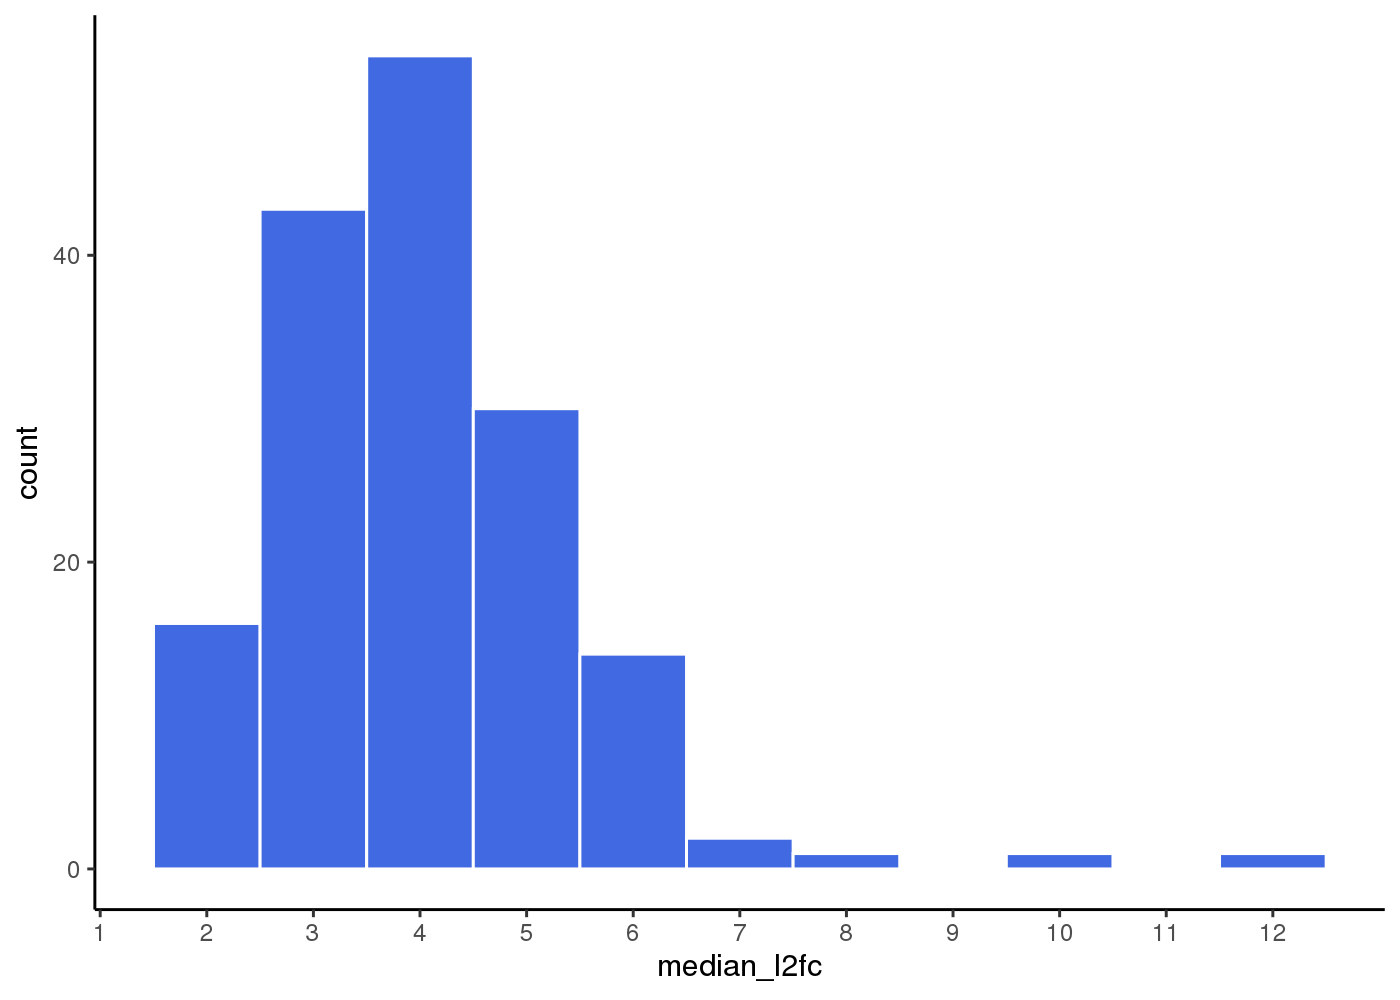

In [11]:
# plot median score distribution
median.screen.data %>% ggplot() + geom_histogram(aes(median_l2fc), binwidth = 1, color = "white", fill = "royalblue") +
                        scale_x_continuous(breaks = seq(0, 12)) + theme_classic()

# Combine analysis between TF's crispr screen result and motif similarity against NGN2

In [12]:
# Get only NGN2's tomtom comparisons
NGN2_tomtom <-  filter(tomtom.ed, query_ID %in% c("MA0669.1", "MA1642.1")) %>% # NGN2's two motifs
                    select(target_ID, p) %>%
                    group_by(target_ID) %>% # group by comparying target
                    summarise(P = min(p)) # take the smaller p value of each two

In [13]:
# get motif names (similar to gene name but not exactly the same, because of versions, and dimers)
NGN2_tomtom <- left_join(NGN2_tomtom, JASPAR_META[, 1:2], by = c("target_ID" = "ID")) 

In [14]:
# complement with crispr screen data
NGN2_tomtom <- mutate(NGN2_tomtom, median_l2fc = map_dbl(Name, ~ getScreenScore(.x, median.screen.data))) %>%
                filter(!is.na(median_l2fc))

In [15]:
NGN2_tomtom %>% head

target_ID,P,Name,median_l2fc
<chr>,<dbl>,<chr>,<dbl>
MA0002.1,0.6235070,RUNX1,5.149426
MA0003.4,0.0034506,TFAP2A,4.380018
MA0014.3,0.7386330,PAX5,4.259507
MA0017.2,0.2806740,NR2F1,6.671046
MA0024.3,0.8610100,E2F1,5.738699
MA0027.2,0.5531230,EN1,2.947371


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


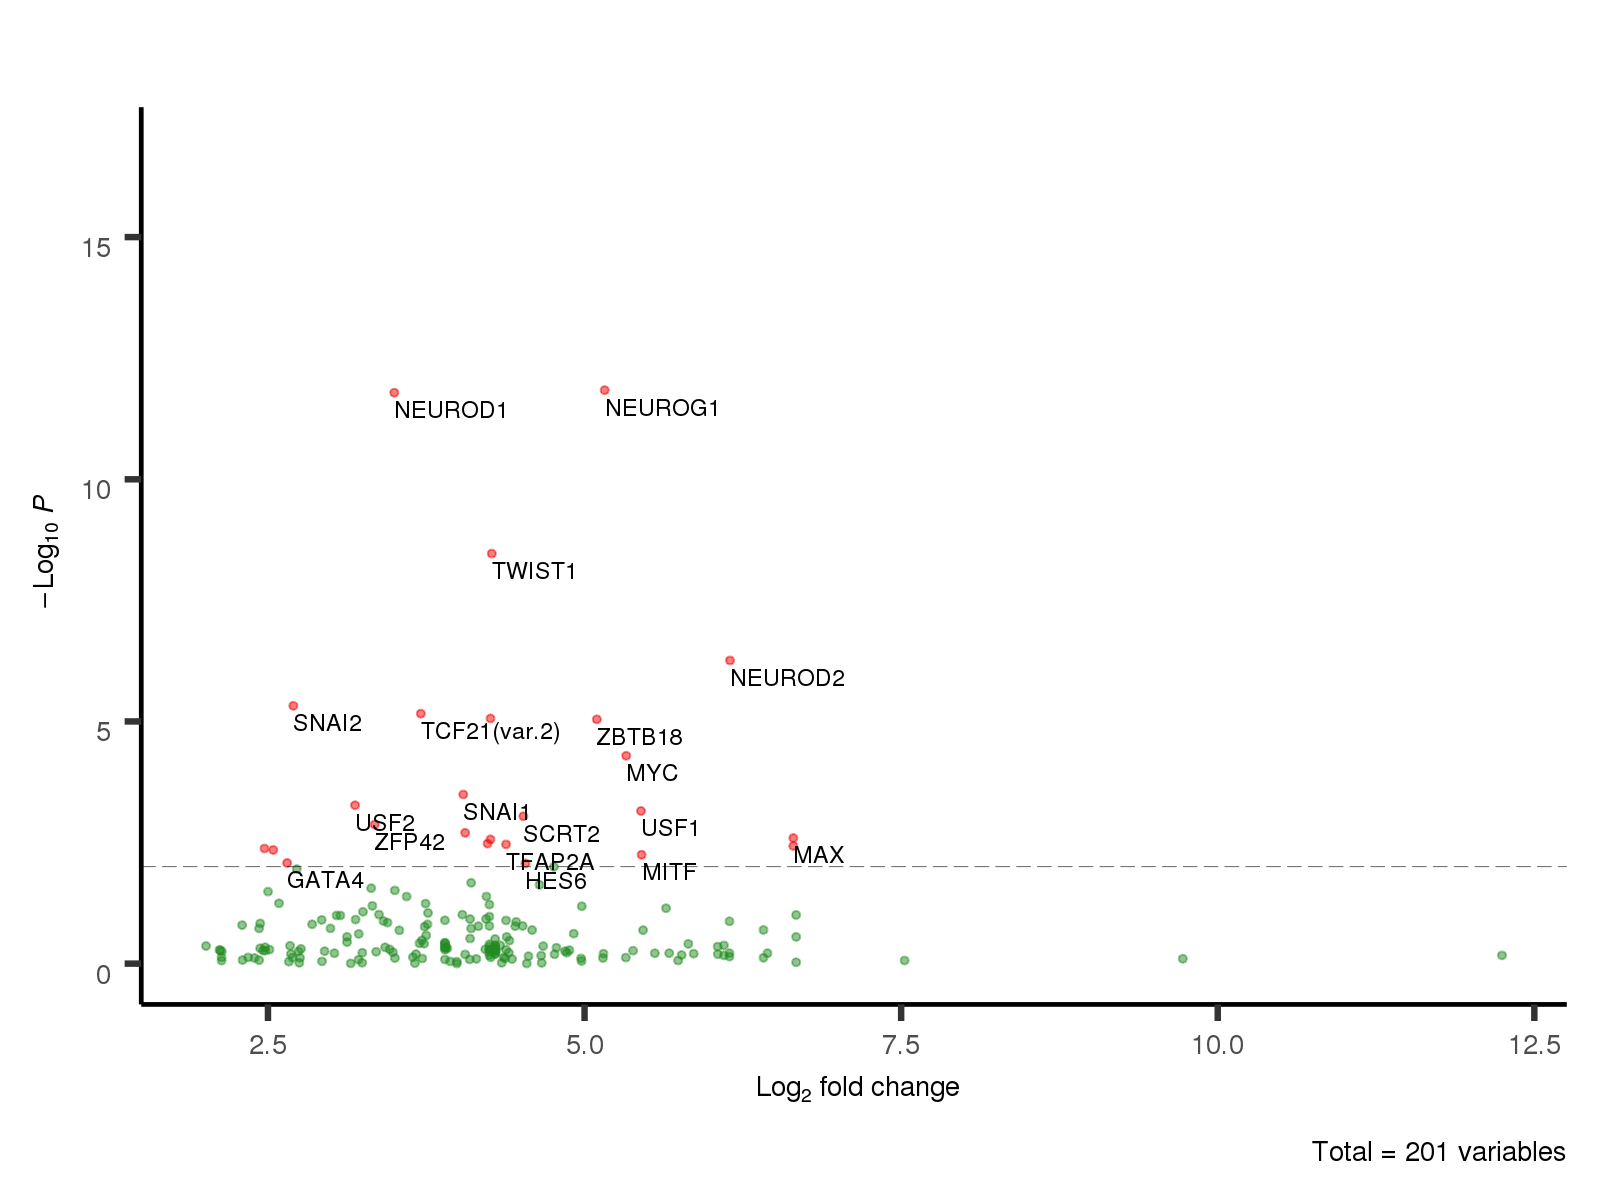

In [82]:
# pdf("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/syncClusterCloud/plots/motif_Similarity_Screen_Volcano.pdf", 
#     width = 10, height = 8)

EnhancedVolcano(NGN2_tomtom, lab = NGN2_tomtom$Name, x = "median_l2fc", y = "P", 
                pointSize = 1,
                    pCutoff = 1e-2, FCcutoff = 0,
                    legendPosition = 'none', 
                    title = "", subtitle = '',titleLabSize = 0,subtitleLabSize = 0,
                    axisLabSize = 10, captionLabSize = 10,
                    cutoffLineWidth = 0.1,
                    gridlines.major = F, gridlines.minor = F)

# dev.off()

In [353]:
library(tictoc)

In [392]:
th <- 1e-2

In [409]:
NGN2_tomtom.box <- mutate(NGN2_tomtom, Pcat = if_else(P < 1e-2, paste0("P < ", th), paste0("P > ", th)))
similar <- filter(NGN2_tomtom.box, str_detect(Pcat, "P <"))
nsimilar <- filter(NGN2_tomtom.box, str_detect(Pcat, "P >"))

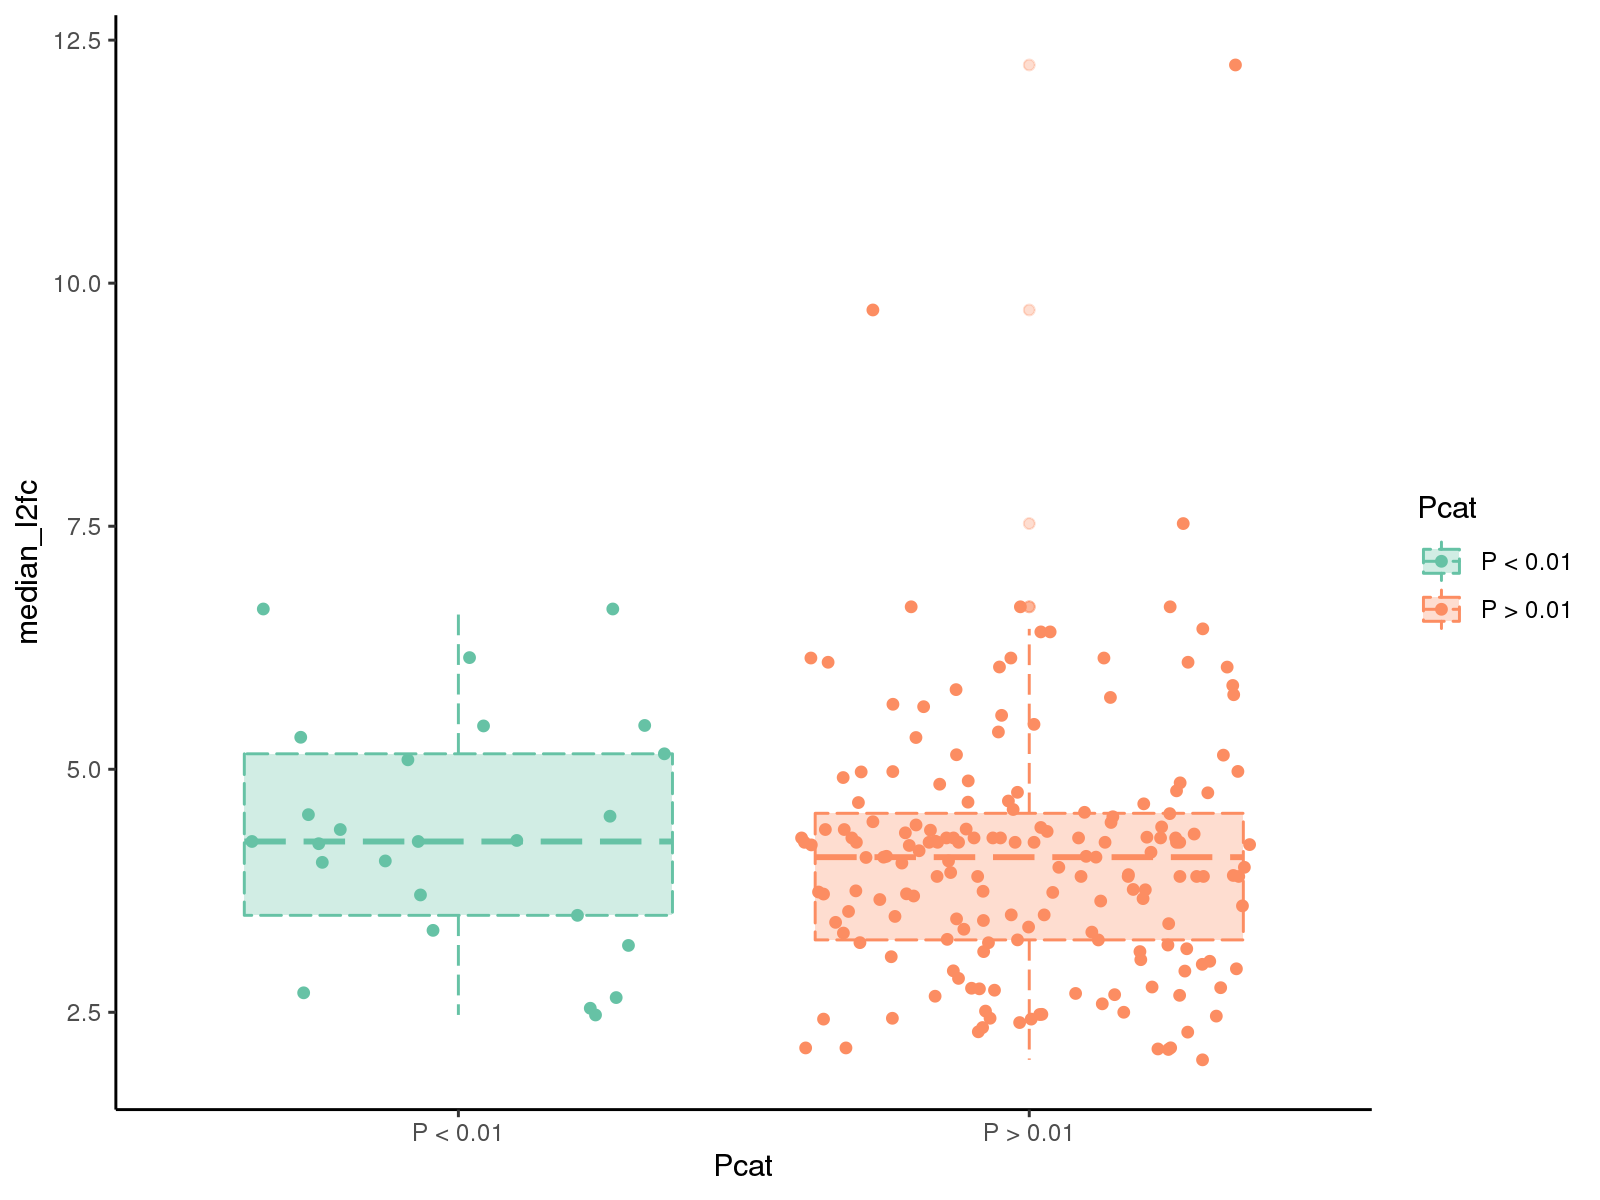

In [410]:
ggplot(NGN2_tomtom.box) + geom_boxplot(aes(Pcat, median_l2fc, fill = Pcat, color = Pcat), 
                                       alpha = .3, linetype = "longdash") +
    geom_point(aes(Pcat, median_l2fc, color = Pcat), position = "jitter") +
    theme_classic() +
    scale_fill_brewer(palette = "Set2") +
    scale_color_brewer(palette = "Set2")

In [419]:
tic()


p.vals <- list()
for (i in 1:5000) {
    nsimilar1 <- nsimilar[sample(1:nrow(nsimilar), nrow(similar), replace = F), ]
    m1 <- lm(median_l2fc~Pcat, rbind(nsimilar1, similar))
    p.vals[[i]] <- anova(m1)$`Pr(>F)`[1]
}

toc()

22.529 sec elapsed


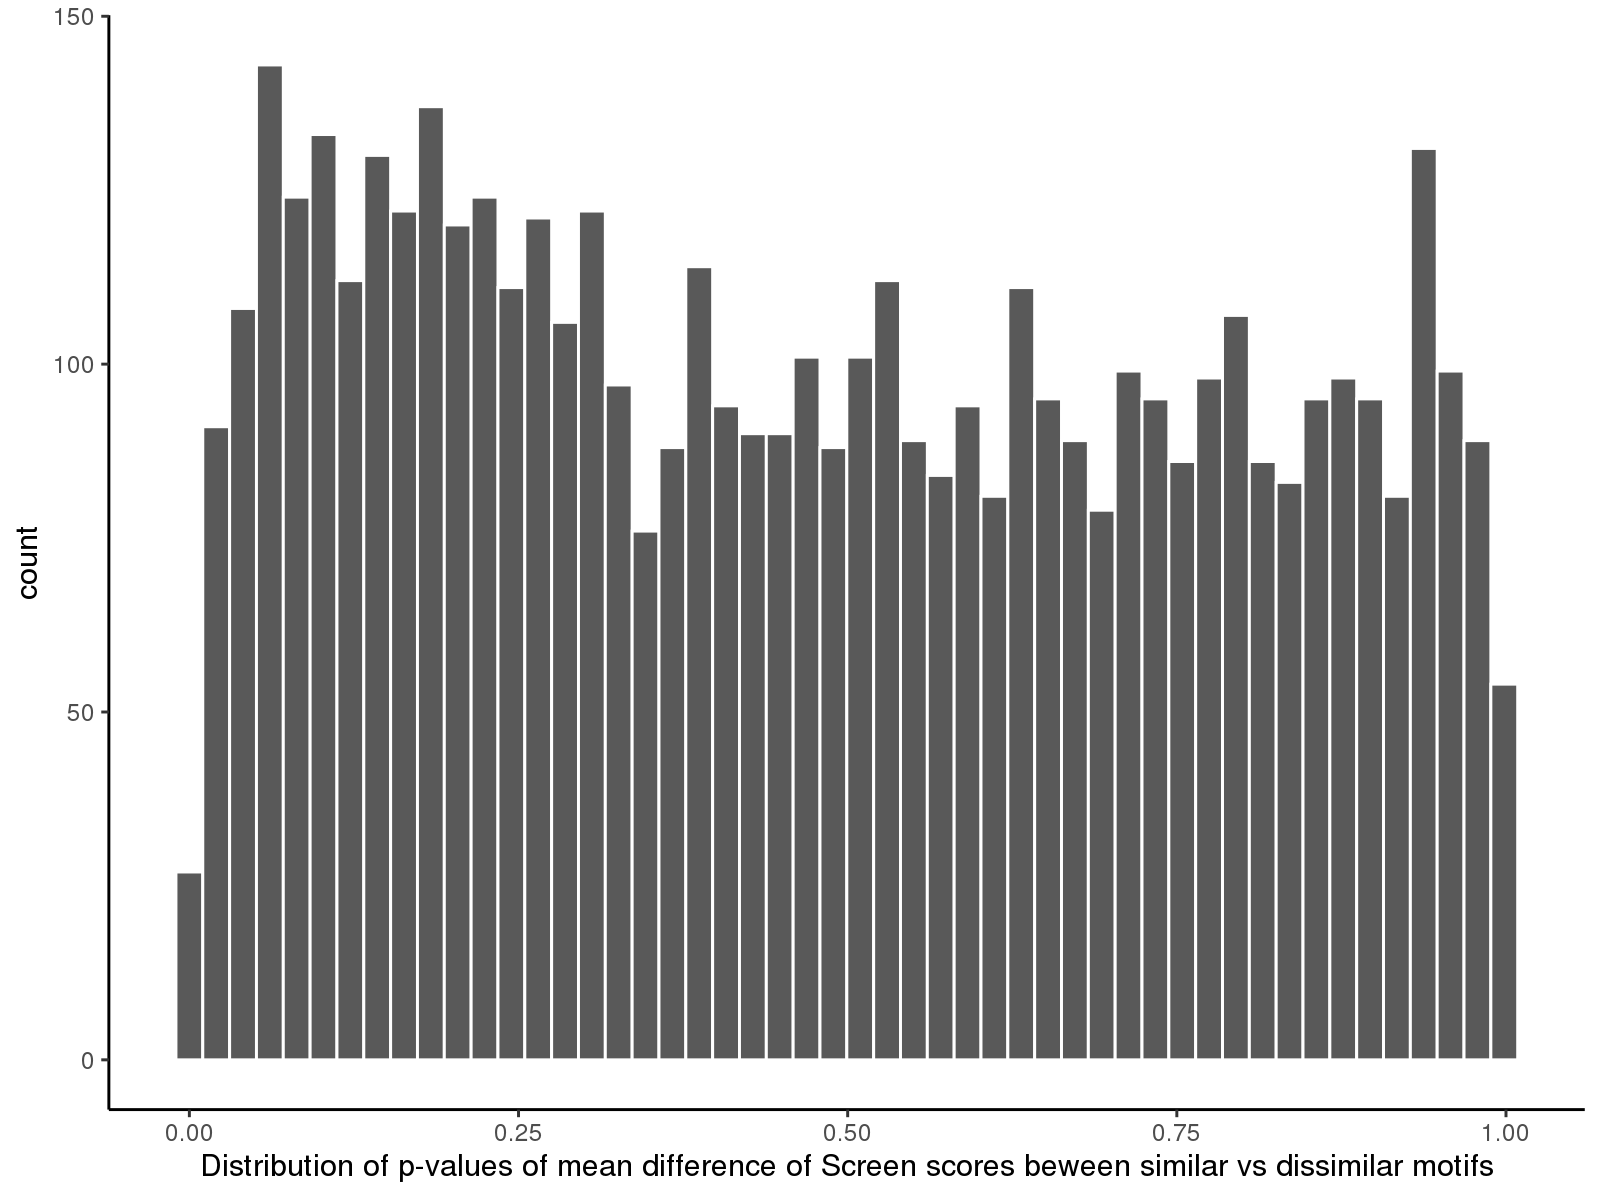

In [420]:
tibble(p = unlist(p.vals)) %>% ggplot() +
    geom_histogram(aes(p), bins = 50, color = "white") + 
    theme_classic() +
    labs(x = "Distribution of p-values of mean difference of Screen scores beween similar vs dissimilar motifs")

---

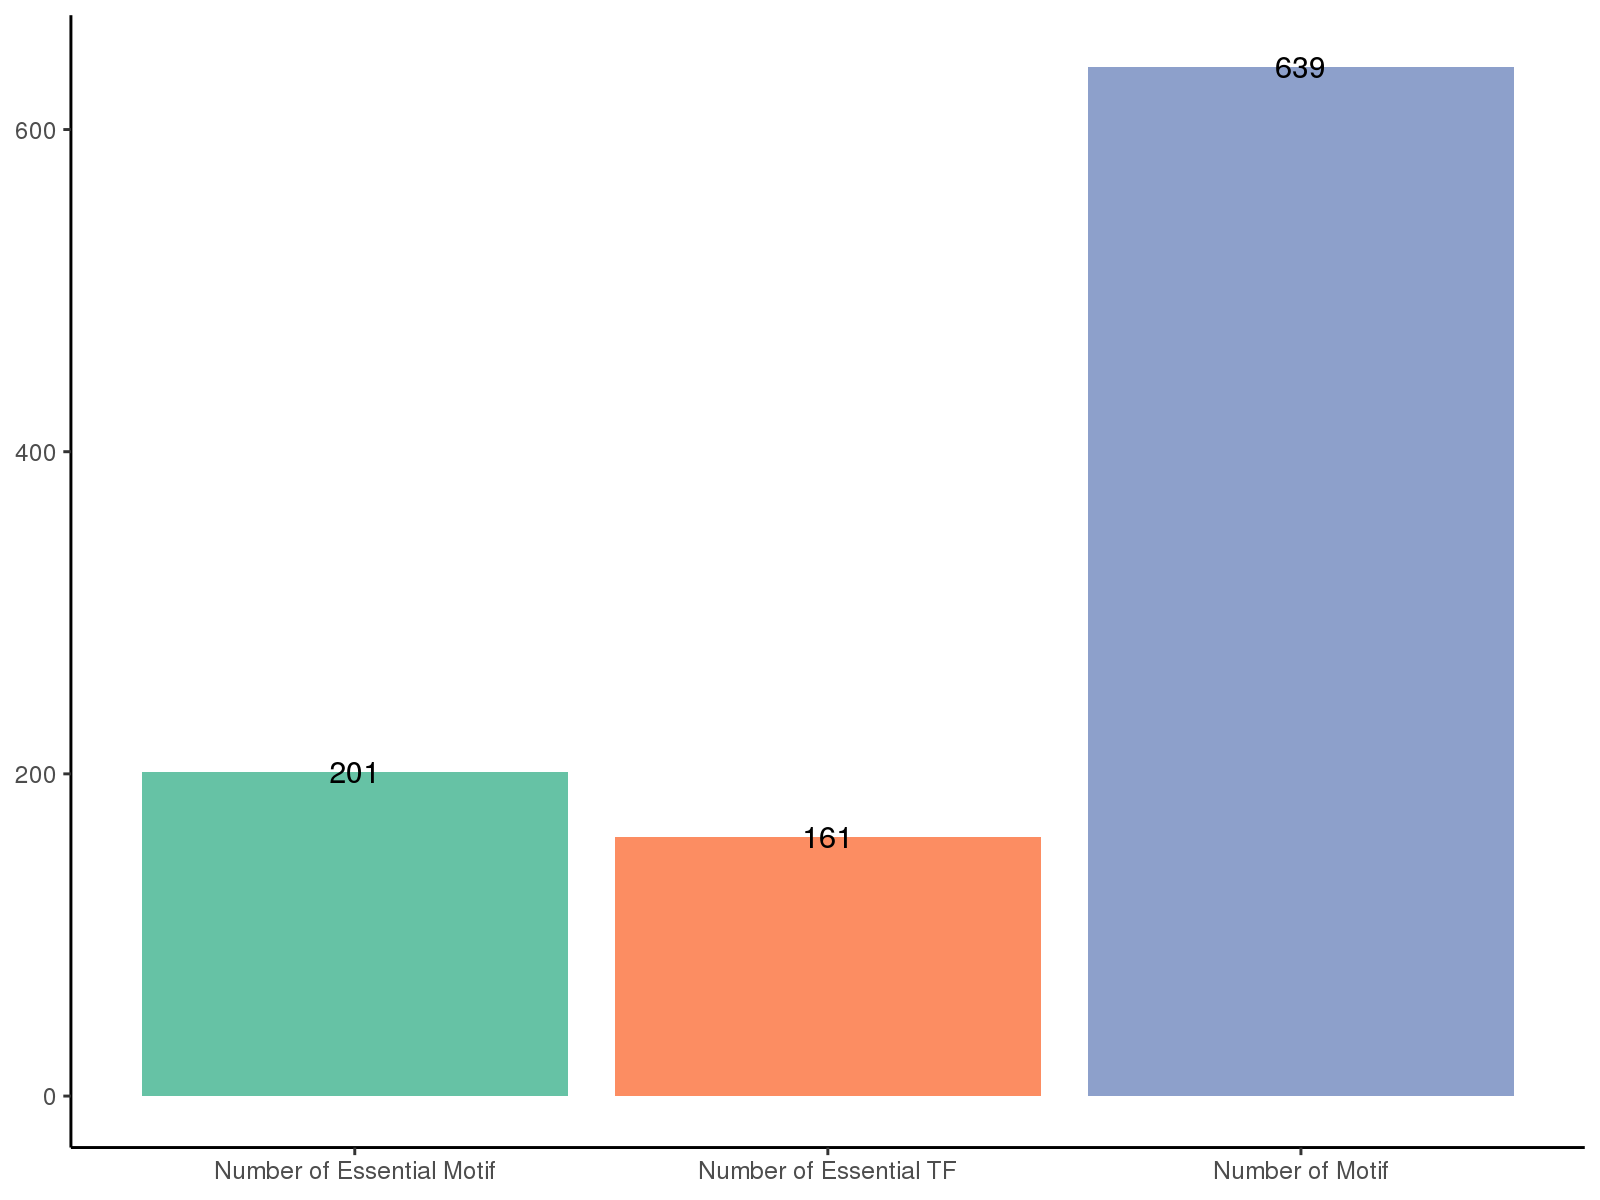

In [83]:
x = tribble(~ cat, ~ count,
           "Number of Motif", 639,
           "Number of Essential TF", 161,
           "Number of Essential Motif", 201)
ggplot(x) + geom_col(aes(cat, count, fill = cat)) +
    geom_text(aes(cat, count, label = count)) +
    theme_classic() +
    scale_fill_brewer(palette = "Set2") +
    labs(x = NULL, y = NULL) +
    theme(legend.position = "none")

**_write data to csv_**

# ChIP peak width

In [805]:
narrowpeaks.ngn2 <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/mouse_chip_mazzoni/macs2/NGN2_WT_rmChr_rmBlack_FC10_peaks.narrowPeak", col_names = F) %>% 
                        select(X1:X3) %>% rename(chr = X1, start = X2, end = X3) %>% mutate(peak_width = end - start)
narrowpeaks.zb <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/mouse_chip_mazzoni/macs2/ZB18_WT_rmChr_rmBlack_FC10_peaks.narrowPeak", col_names = F) %>%
                        select(X1:X3) %>% rename(chr = X1, start = X2, end = X3) %>% mutate(peak_width = end - start)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double()
)



In [844]:
narrowpeaks.ngn2$peak_width %>% summary
narrowpeaks.zb$peak_width %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    235     413     508     575     665    2871 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  213.0   422.0   544.0   618.1   732.0  3350.0 

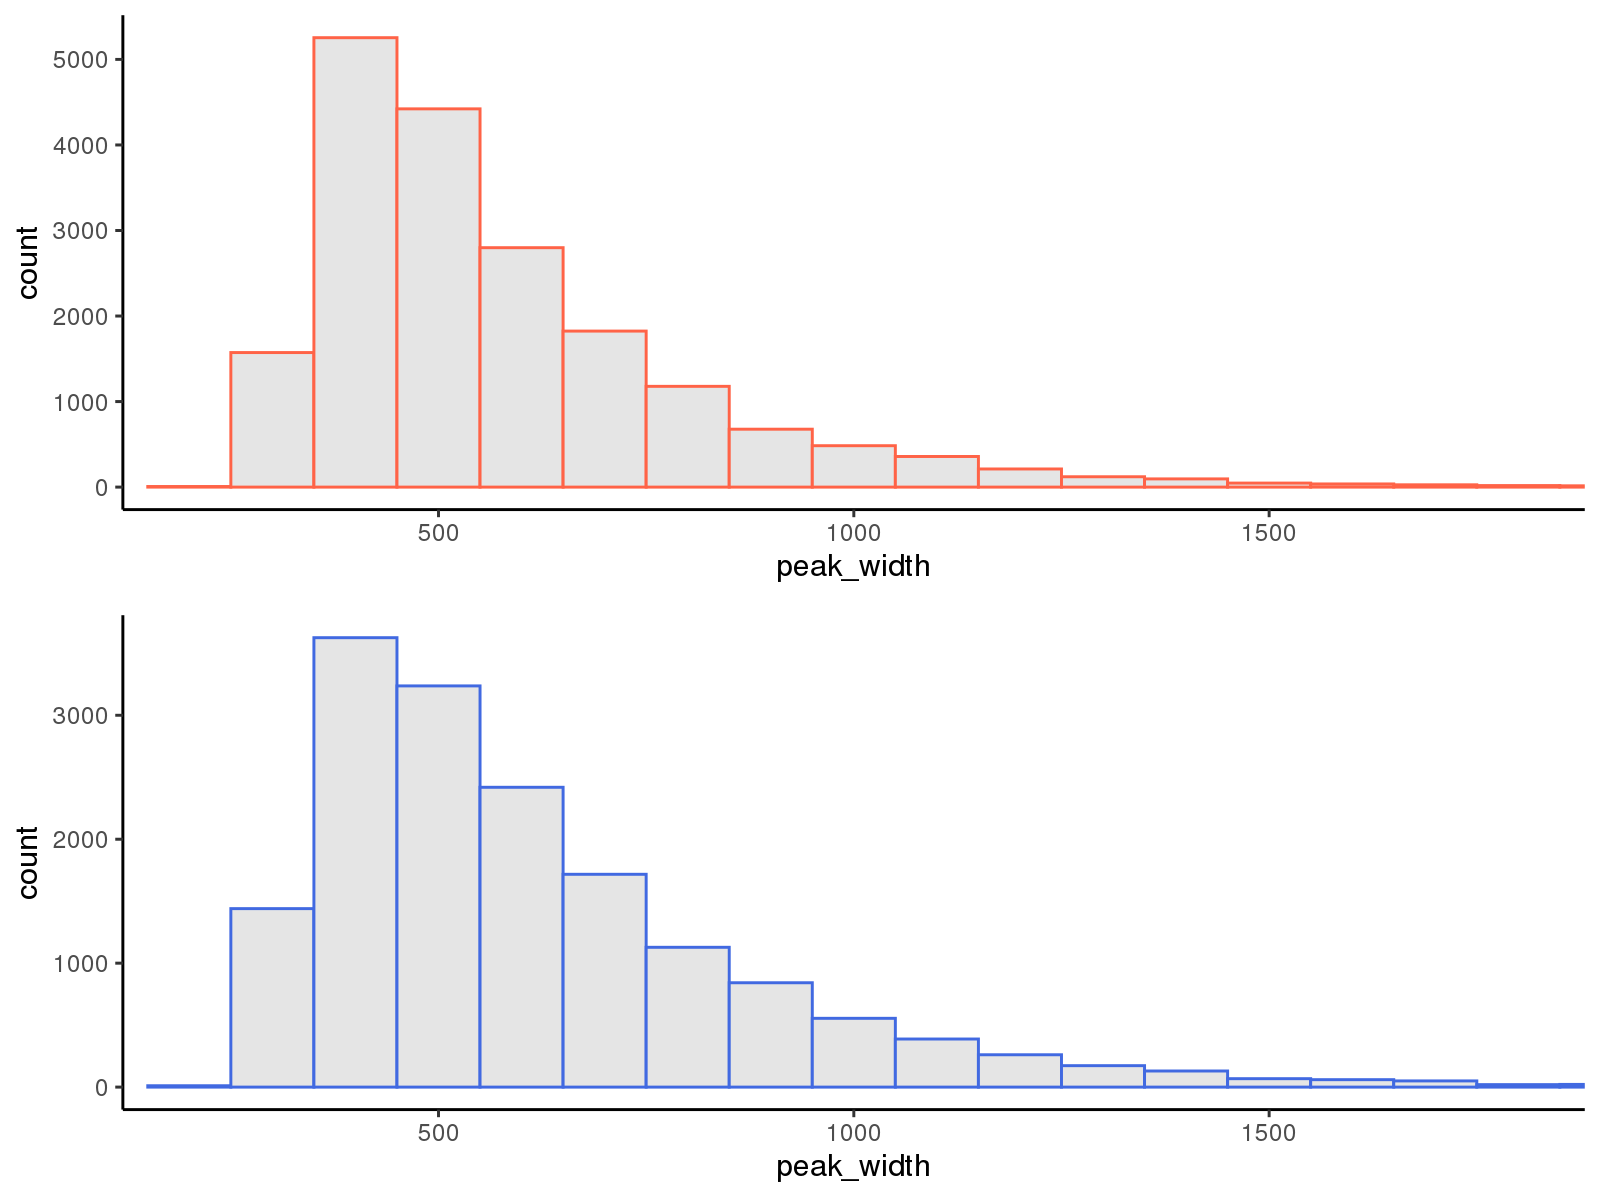

In [842]:
g1 <- ggplot(narrowpeaks.ngn2) + geom_histogram(aes(peak_width), color = "tomato", fill = "grey90", binwidth = 100) + 
        theme_classic() +
        coord_cartesian(xlim = c(200,1800)) +
g2 <- ggplot(narrowpeaks.zb) + geom_histogram(aes(peak_width), color = "royalblue", fill = "grey90", binwidth = 100) + 
        theme_classic() +
        coord_cartesian(xlim = c(200,1800))
gridExtra::grid.arrange(g1, g2, nrow = 2)

# Coocupancy between NGN2 and ZBTB18

In [904]:
overlap.sites <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/mouse_chip_mazzoni/macs2/NGN2_ZB18_overlap_Sites_anno.bed",
                            col_names = c("chrA", "startA", "endA", "peakA", "fcA", "chrB", "startB", "endB", "peakB", "fcB", "overlap", "gene"))

adjacent.sites <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/mouse_chip_mazzoni/macs2/NGN2_ZB18_adjacent_sites_anno.bed", 
                             col_names = c("chrA", "startA", "endA", "peakA", "fcA", "chrB", "startB", "endB", "peakB", "fcB", "distance", "gene"))

Parsed with column specification:
cols(
  chrA = col_character(),
  startA = col_double(),
  endA = col_double(),
  peakA = col_character(),
  fcA = col_double(),
  chrB = col_character(),
  startB = col_double(),
  endB = col_double(),
  peakB = col_character(),
  fcB = col_double(),
  overlap = col_double(),
  gene = col_character()
)

Parsed with column specification:
cols(
  chrA = col_character(),
  startA = col_double(),
  endA = col_double(),
  peakA = col_character(),
  fcA = col_double(),
  chrB = col_character(),
  startB = col_double(),
  endB = col_double(),
  peakB = col_character(),
  fcB = col_double(),
  distance = col_double(),
  gene = col_character()
)



In [901]:
hitlist <- read_csv("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/Hitlist_20191230.csv")
tflist <- read_csv("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/TFlist_20191230.csv")

Parsed with column specification:
cols(
  gene_name = col_character(),
  hgnc_symbol = col_character()
)

Parsed with column specification:
cols(
  gene_name = col_character(),
  hgnc_symbol = col_character()
)



In [905]:
overlap.sites <- mutate(overlap.sites, isHit = gene %in% hitlist$hgnc_symbol) %>% mutate(isTF = gene %in% tflist$hgnc_symbol)
adjacent.sites <- mutate(adjacent.sites, isHit = gene %in% hitlist$hgnc_symbol) %>% mutate(isTF = gene %in% tflist$hgnc_symbol)

In [906]:
adjacent.sites$distance %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   11.00   27.00   81.61   66.00  688.00 

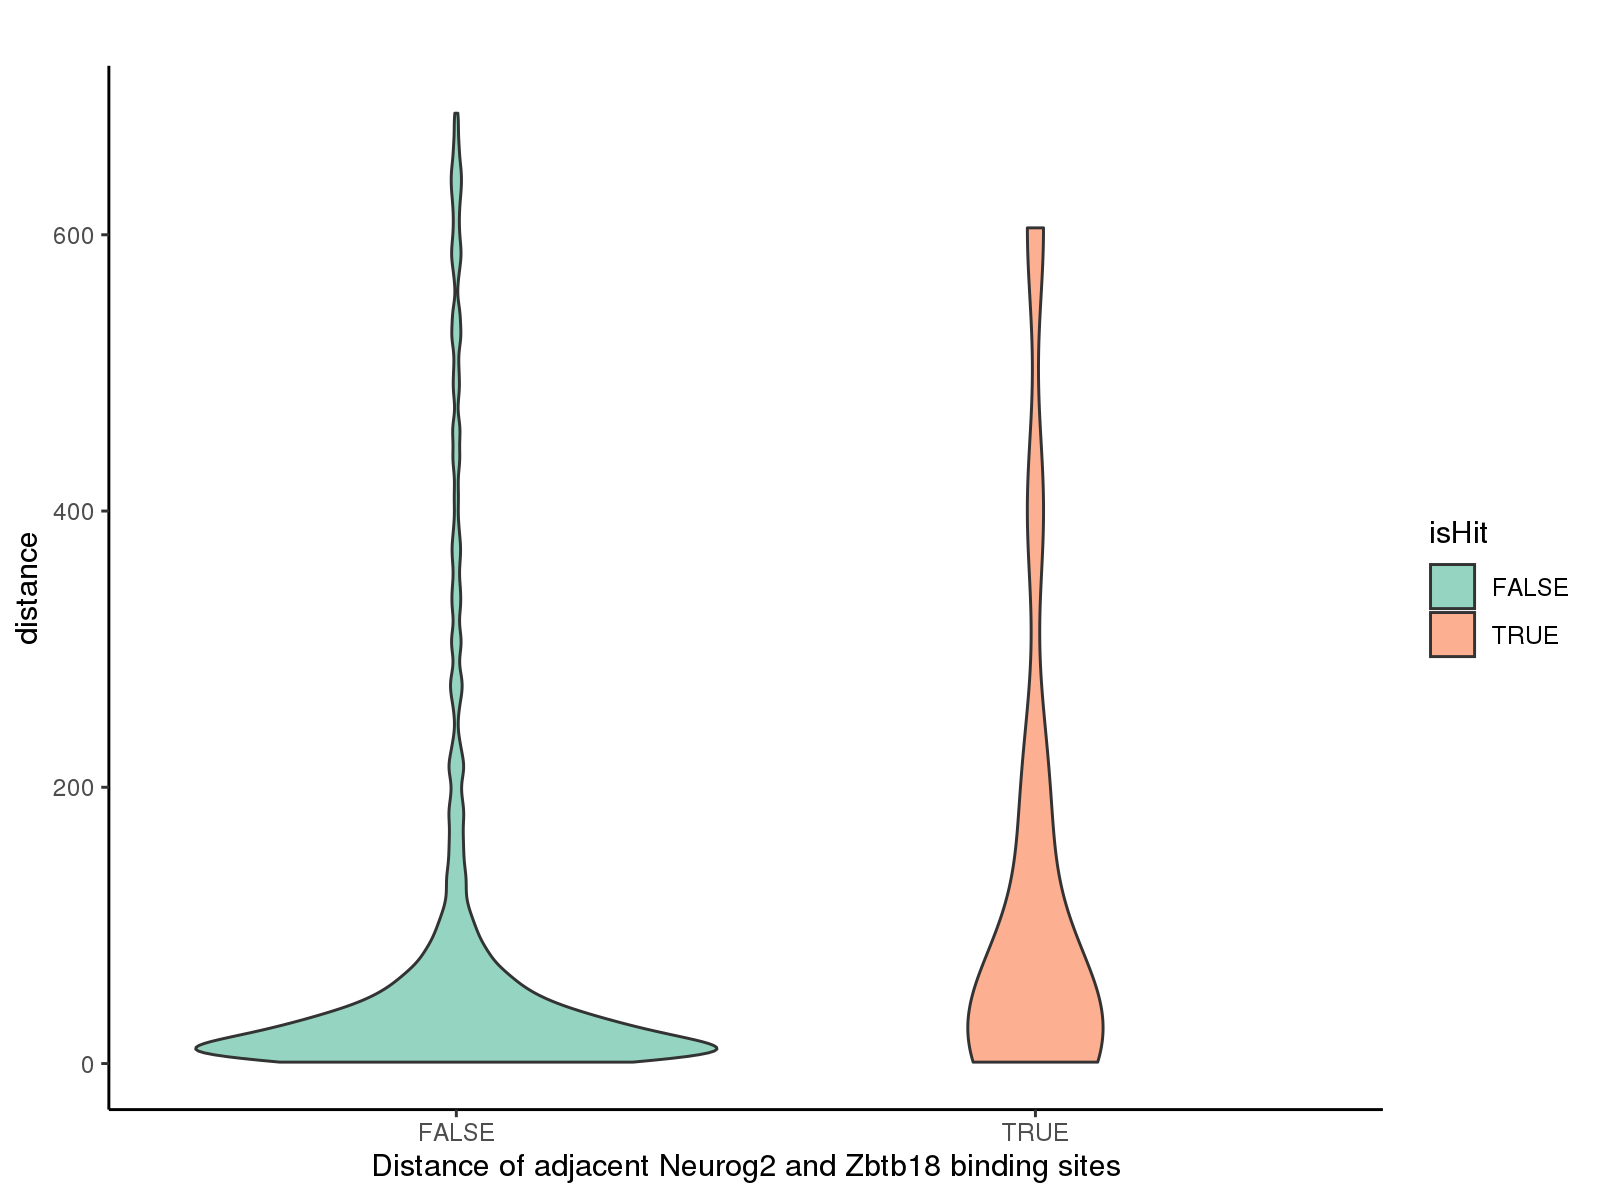

In [942]:
adjacent.sites %>%
        ggplot() + geom_violin(aes(isHit, distance, fill = isHit), alpha = .7) +
        theme_classic() +
        scale_fill_brewer(palette = "Set2") +
        labs(x = "Distance of adjacent Neurog2 and Zbtb18 binding sites", title = "")

In [983]:
# permutation test
N = dim(adjacent.sites)[1]
SIZE = filter(adjacent.sites, isHit) %>% pull(distance) %>% length

perm.test <- c()
for (i in 1:2000) {
    chosen.mean <- adjacent.sites[sample(N,SIZE),] %>% pull(distance) %>% mean
    unchosen.mean <- adjacent.sites[-sample(N,SIZE),] %>% pull(distance) %>% mean
    perm.test[i] <- chosen.mean <= unchosen.mean   
}

sum(perm.test) / length(perm.test) # if this is smaller than 0.05 then significant

[1] 0.559

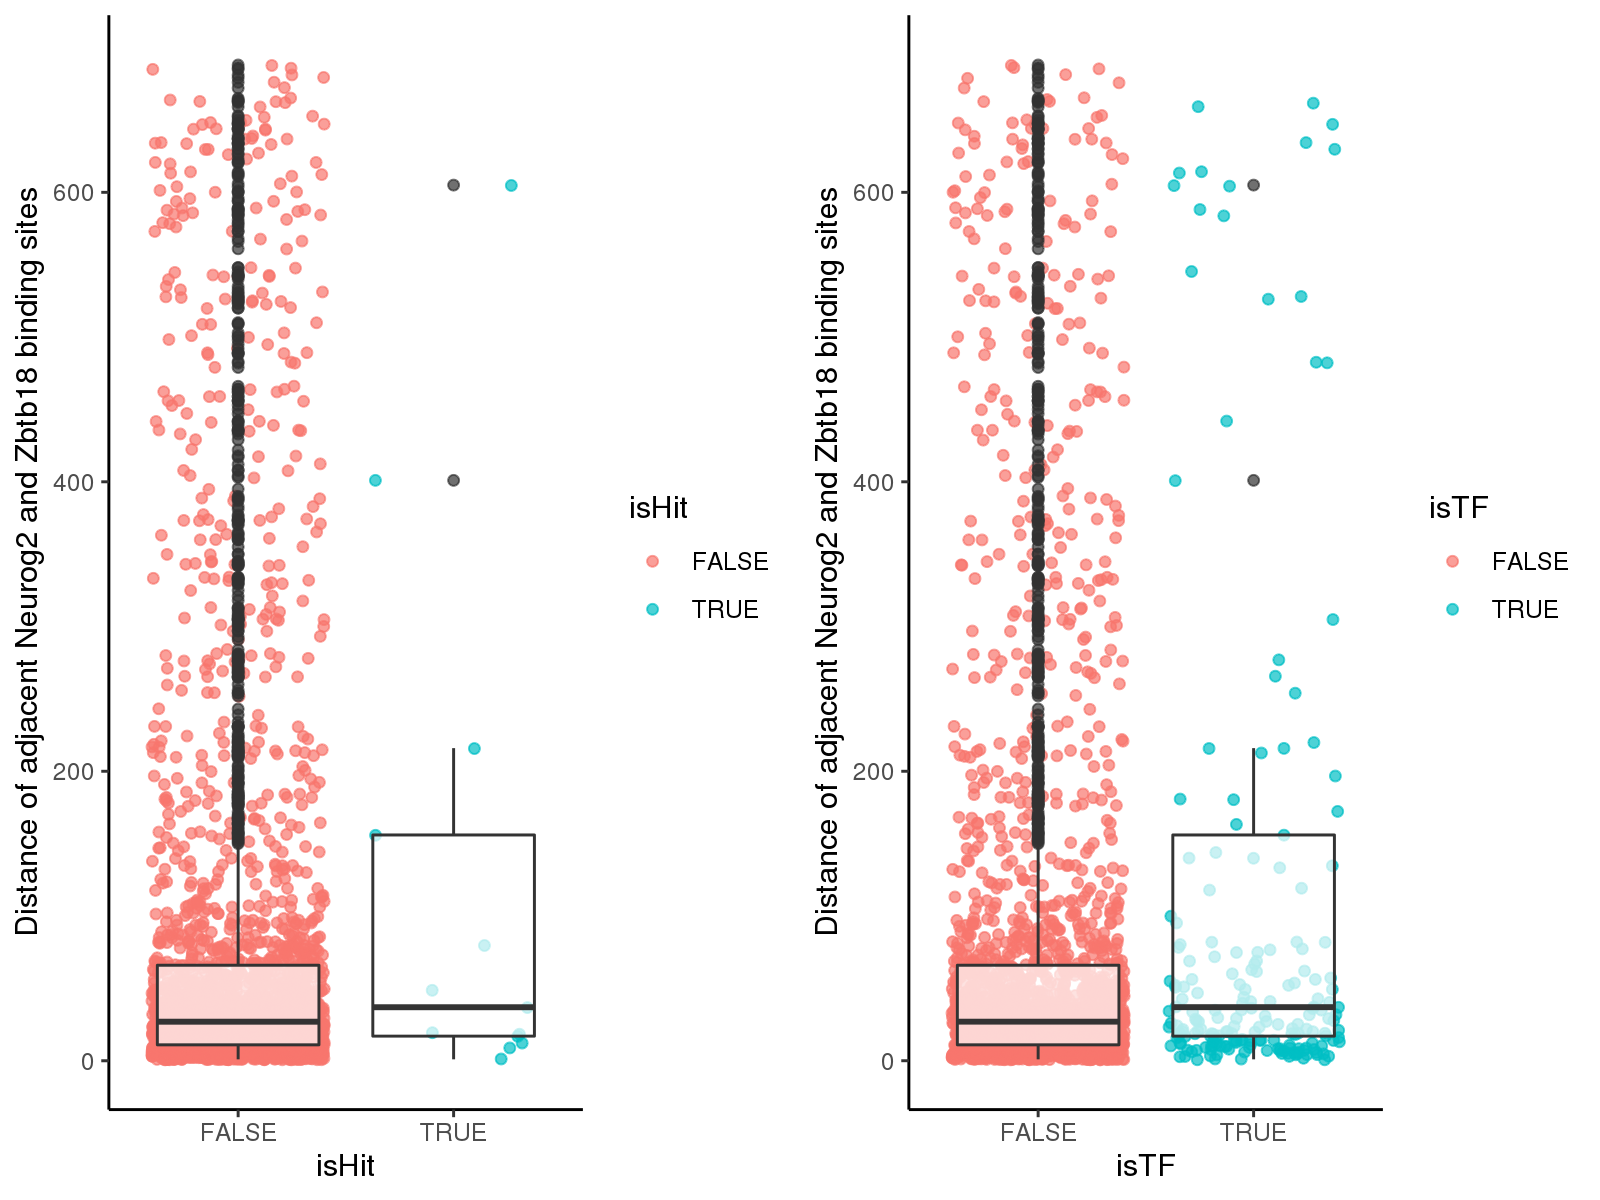

In [911]:
g3 <- ggplot(adjacent.sites) + geom_point(aes(isHit, distance, color = isHit), alpha = 0.7, position = "jitter") +
        geom_boxplot(aes(x = isHit, y = distance), alpha = .7) +
        theme_classic() +
        labs(y = "Distance of adjacent Neurog2 and Zbtb18 binding sites")

g4 <- ggplot(adjacent.sites) + geom_point(aes(isTF, distance, color = isTF), alpha = 0.7, position = "jitter") +
        geom_boxplot(aes(x = isHit, y = distance), alpha = .7) +
        theme_classic() +
        labs(y = "Distance of adjacent Neurog2 and Zbtb18 binding sites")

gridExtra::grid.arrange(g3, g4, nrow = 1)

In [912]:
lm(distance ~ isHit, adjacent.sites) %>% anova

lm(distance ~ isTF, adjacent.sites) %>% anova

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
isHit,1,24185.59,24185.59,1.207885,0.2718681
Residuals,2265,45352287.43,20023.08,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
isTF,1,30117.63,30117.63,1.504342,0.2201319
Residuals,2265,45346355.39,20020.47,NA,NA


In [913]:
overlap.genes <- unique(overlap.sites$gene)
adjacent.genes <- unique(adjacent.sites$gene)

In [916]:
adjacent.genes %>% length
overlap.genes %>% length

[1] 1612

[1] 444

In [919]:
overlap.sites %>% filter(isHit) %>% pull(gene)
adjacent.sites %>% filter(isHit) %>% pull(gene)

[1] "LHX4"   "ARID1B" "SKI"    "RBPJ"

[1] "LHX4"   "CRY1"   "EBF1"   "EBF1"   "NR1I2"  "NR1I2"  "ARID1B" "ARID1B"
 [9] "PAX2"   "PAX2"   "PAX7"   "POU2F3" "SMAD3"

## next check GE in overlap and adjacent genes

In [1001]:
library(fgsea)

Loading required package: Rcpp



In [1022]:
my.gene.set <- list(overlap.only = setdiff(overlap.genes, adjacent.genes), 
                   adjacent.only = setdiff(adjacent.genes, overlap.genes),
                   overlap_and_adjacent = intersect(overlap.genes, adjacent.genes))

In [1130]:
dim(adjacent.sites)
dim(overlap.sites)

[1] 2267   14

[1] 481  14

In [1095]:
my.gene.set %>% 

List of 3
 $ overlap.only        : chr [1:263] "COL19A1" "HS6ST1" "VWA3B" "TSGA10" ...
 $ adjacent.only       : chr [1:1431] "PCMTD1" "SNTG1" "ADHFE1" "CPA6" ...
 $ overlap_and_adjacent: chr [1:181] "RIMS1" "TNS1" "PAX3" "ESPNL" ...


In [1133]:
imap(my.gene.set, ~ length(.x)) %>% 
    as.data.frame %>% 
    pivot_longer(cols = contains("a"), names_to = "type", values_to = "n")

type,n
<chr>,<int>
overlap.only,263
adjacent.only,1431
overlap_and_adjacent,181


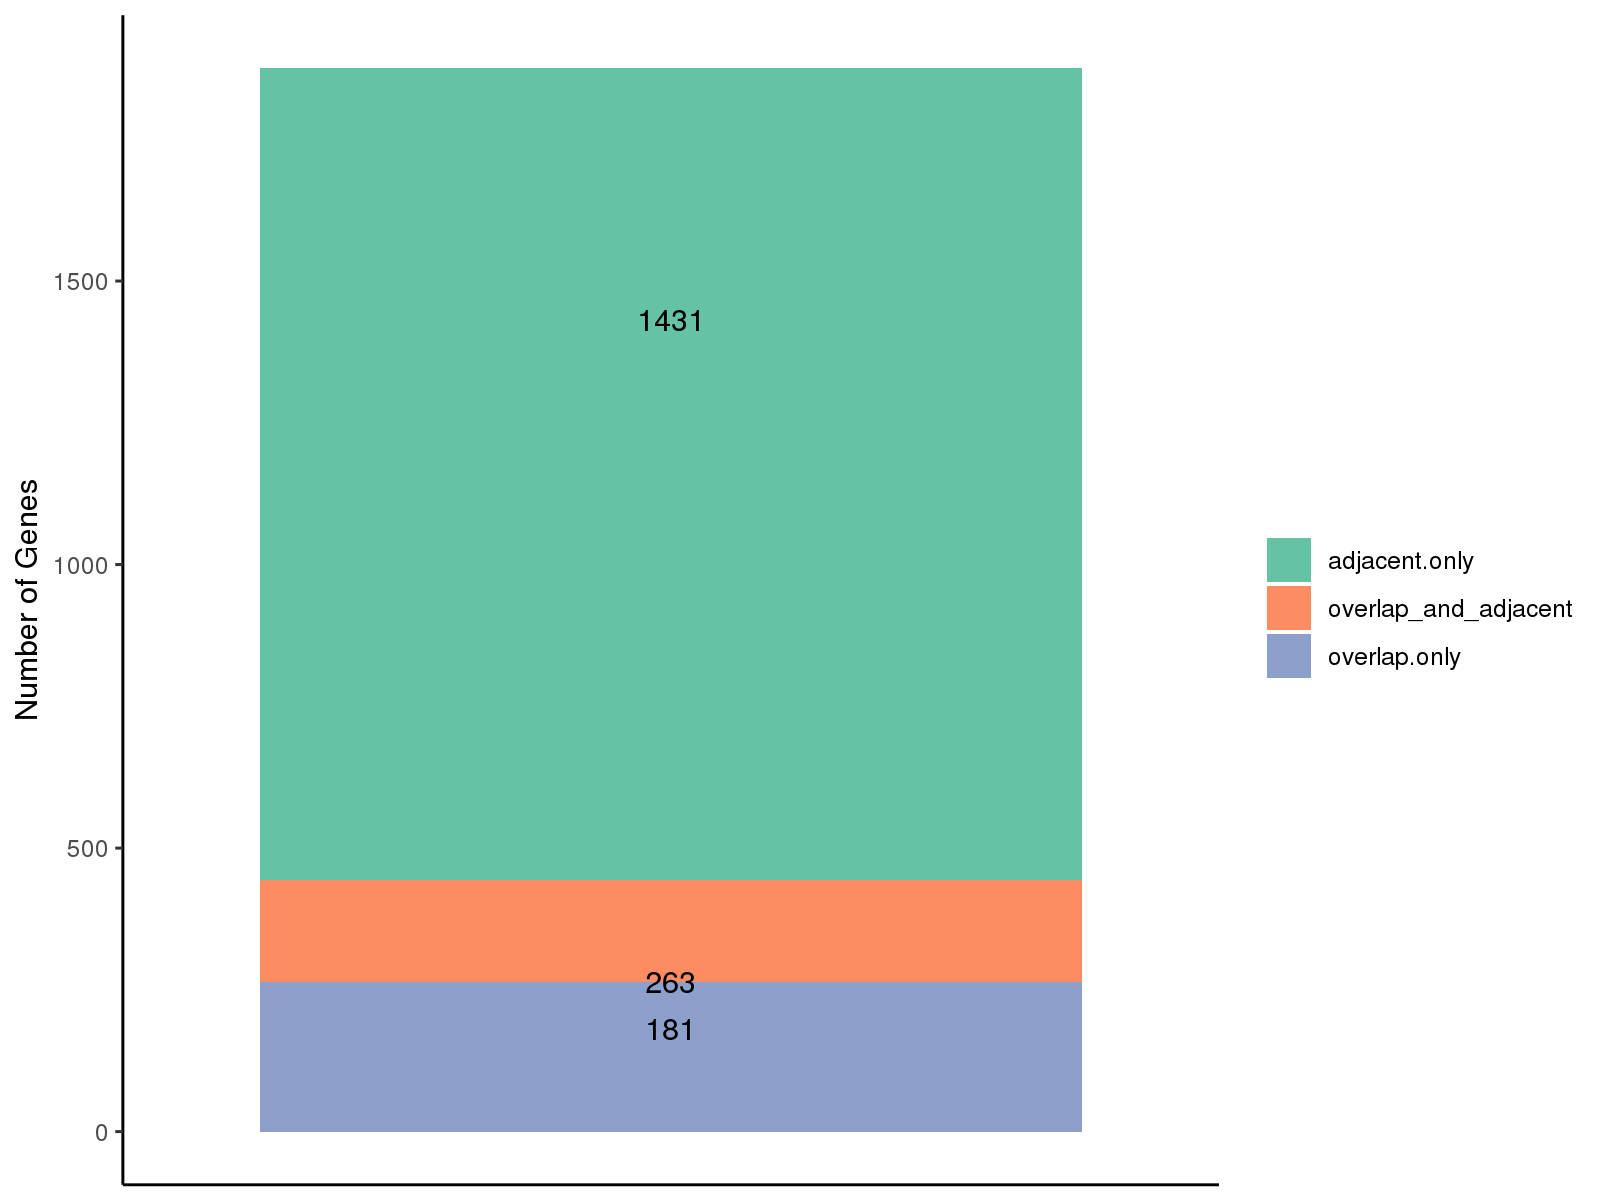

In [1132]:
imap(my.gene.set, ~ length(.x)) %>% 
    as.data.frame %>% 
    pivot_longer(cols = contains("a"), names_to = "type", values_to = "n") %>%
    ggplot() + geom_col(aes(x = "", n, fill = type)) + 
        geom_text(aes(x = "", n, label = n, group = type)) +
        theme_classic() +
        scale_fill_brewer(palette = "Set2", name = NULL) +
        scale_x_discrete(name = NULL, breaks = NULL) +
        labs(y = "Number of Genes")

In [1024]:
readxl::excel_sheets(path = "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/RNA-seq_timepoint_deseq_result_20200102.xlsx")

[1] "rawCounts" "H15_vs_ES" "D1_vs_ES"  "D2_vs_ES"  "D4_vs_ES"  "D7_vs_ES"

In [1062]:
D4.ZB18.KO <- read_csv("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/Day4_WT_vs_ZBTB18_KO_sigGenes.csv")

Parsed with column specification:
cols(
  gene_id = col_character(),
  gene = col_character(),
  padj = col_double(),
  log2FoldChange = col_double(),
  S07_B1 = col_double(),
  S07_B2 = col_double(),
  S08_B1 = col_double(),
  S08_B2 = col_double(),
  S09_B1 = col_double(),
  S09_B2 = col_double(),
  S10_B1 = col_double(),
  S10_B2 = col_double(),
  S11_B1 = col_double(),
  S11_B2 = col_double(),
  S12_B1 = col_double(),
  S12_B2 = col_double(),
  expression = col_character()
)



In [1073]:
ZBKO.rank <- select(D4.ZB18.KO, gene, log2FoldChange) %>% deframe

In [1074]:
fgseaRes1 <- fgsea(pathways = my.gene.set, stats = ZBKO.rank, nperm = 1000)

In [1075]:
fgseaRes1

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
overlap.only,0.1076923,0.3230769,-0.3153664,-1.2861069,20,27,"CNTN4 , ANO4 , RTN4RL1, NECAB2 , SH3GL2 , FAM13C , CASZ1"
adjacent.only,0.9352518,0.9352518,0.1867806,0.7242155,909,139,"WNT10A , GLI2 , EPHA1 , NEK11 , LAMA4 , SPON1 , PRR5L , SLC39A8 , ALK , FBN1 , SYT6 , STRA6 , ATOH8 , CCDC33 , SEMA5A , PAG1 , EDA , ANGPT4 , CLMP , MOB3B , PTPN14 , IGF1 , LMX1B , PDGFRB , DCC , ARAP1 , KCND3 , SHROOM3 , STXBP6 , PPARGC1B, SMAD3 , SORL1 , SMCO4 , RTKN , ANKRD33B, ITPR1 , PHACTR2 , PRICKLE2, PHLDB2 , EPHB4 , PDLIM4 , WWTR1 , ZMAT4 , BCHE"
overlap_and_adjacent,0.9132590,0.9352518,0.2116601,0.6452026,736,27,"PDPN , SCARA5 , SOX6 , SUSD4 , PRICKLE1, CD82 , PRKCB , FGFR2 , PDE10A , ANTXR1"


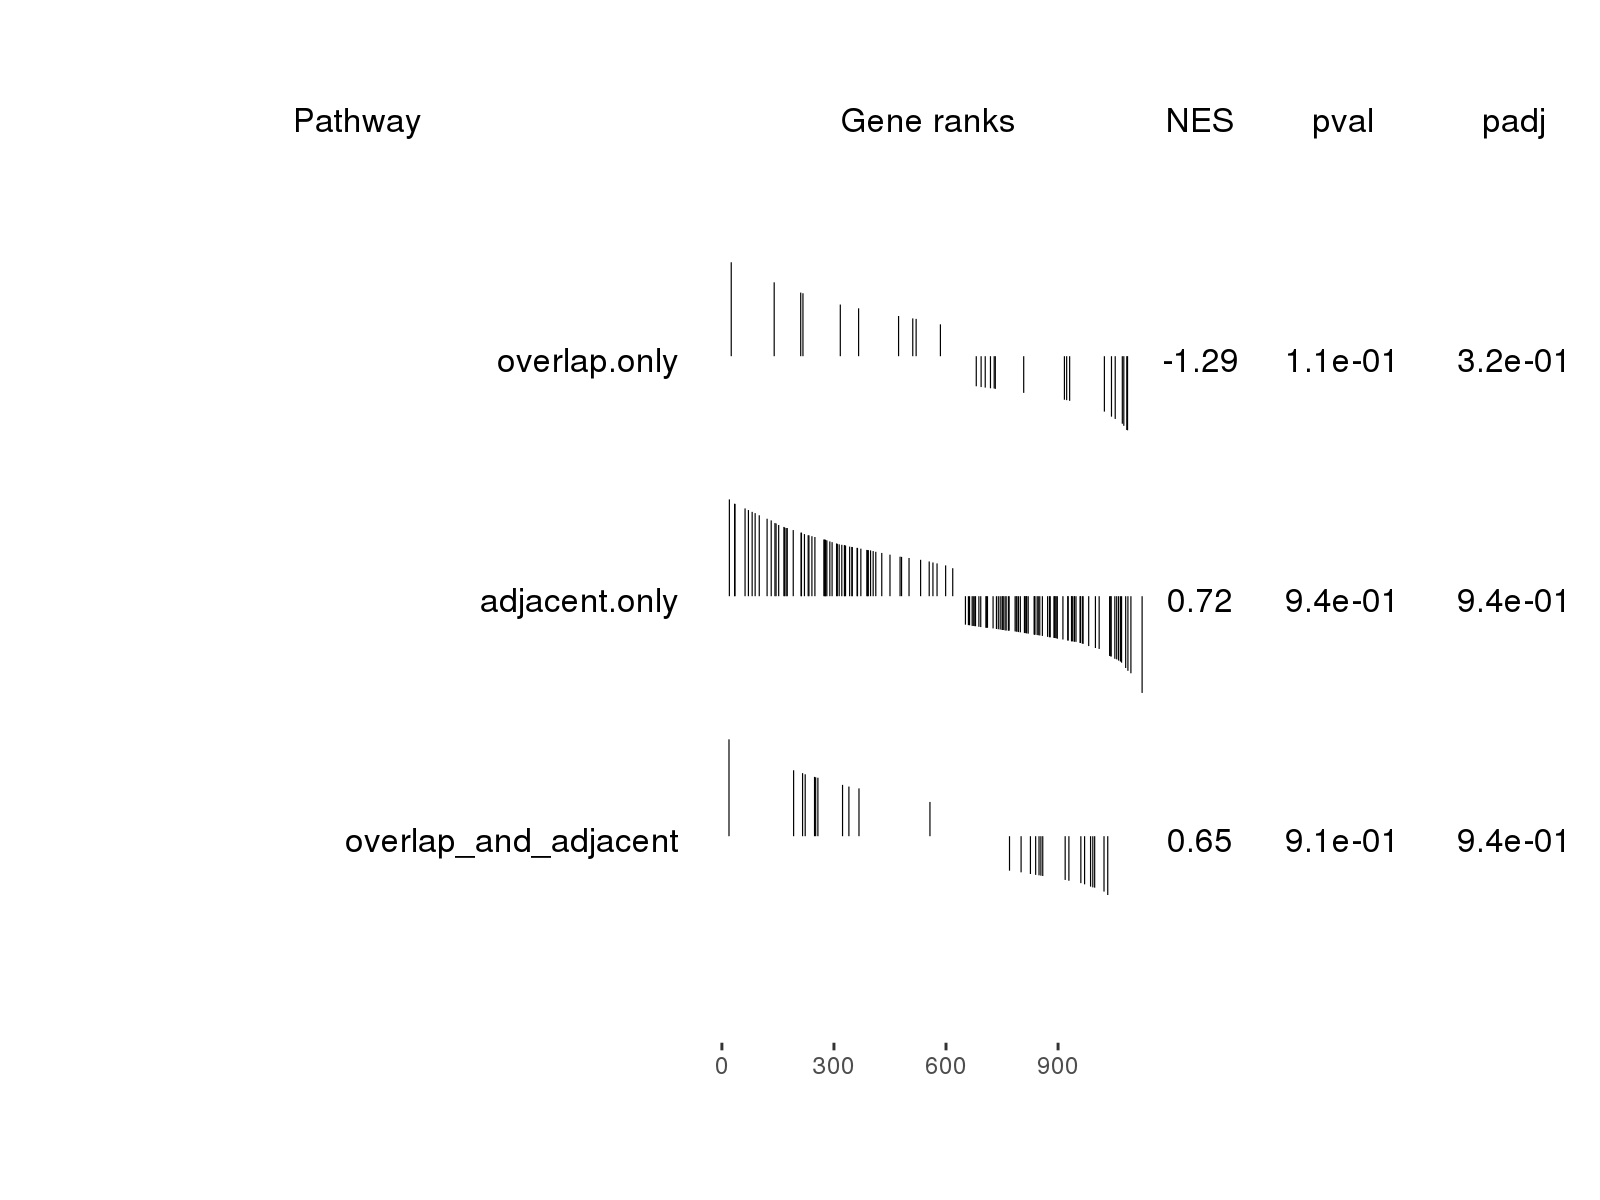

In [1076]:
plotGseaTable(my.gene.set, ZBKO.rank, fgseaRes1, gseaParam = .5)

In [1134]:
D7.WT <- readxl::read_xlsx('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/RNA-seq_timepoint_deseq_result_20200102.xlsx', sheet = 'D7_vs_ES')

In [1135]:
head(D7.WT)

gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003.14,1093.2455416,-1.2998652,0.1841414,-7.059060,1.676324e-12,2.500888e-11,TSPAN6
ENSG00000000005.6,4.2712569,-5.4619627,2.2687624,-2.407464,1.606377e-02,4.193408e-02,TNMD
ENSG00000000419.12,562.8246277,-0.4335166,0.3066240,-1.413838,1.574096e-01,2.662829e-01,DPM1
ENSG00000000457.14,66.6639588,0.9733724,0.8216719,1.184624,2.361660e-01,3.629106e-01,SCYL3
ENSG00000000460.17,134.9026604,-3.0439906,0.7900719,-3.852802,1.167738e-04,5.509179e-04,C1orf112
ENSG00000000938.13,0.3862281,0.0000000,4.8388833,0.000000,1.000000e+00,NA,FGR


In [1137]:
D7.WT <- select(D7.WT, gene_name, log2FoldChange) %>% deframe

In [1138]:
fgseaRes2 <- fgsea(pathways = my.gene.set, stats = D7.WT, nperm = 1000)

Warning message in fgsea(pathways = my.gene.set, stats = D7.WT, nperm = 1000):
“There are ties in the preranked stats (1.58% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = my.gene.set, stats = D7.WT, nperm = 1000):
“There are duplicate gene names, fgsea may produce unexpected results”


In [1139]:
fgseaRes2

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
overlap.only,0.016853933,0.016853933,0.3258290,1.334040,11,232,"RTN4RL1 , ASIC1 , GFRA1 , SPTBN4 , GRID1 , LGR5 , GRM8 , CHRNA1 , SVOP , CNTN4 , ANO3 , PEX5L , SLC6A17 , RALGDS , GAS2 , RGS8 , ACSL5 , KCNJ6 , NDST4 , NECAB2 , GRIA2 , CHN2 , RGS6 , TMEFF1 , ALCAM , FRMPD1 , GPM6A , FILIP1L , RAPGEF4 , KIF5A , FAM13C , OTUD7A , CRMP1 , STUM , ANO4 , CCDC62 , DLC1 , CPEB3 , DOK5 , KLC1 , NBEA , KCNH2 , CORIN , CRTC3 , SYT1 , TBC1D24 , ENPP3 , LRP12 , LCOR , TULP4 , AJAP1 , ITGA9 , TMPRSS5 , CLIP3 , SATB2 , SNED1 , AAK1 , FLRT2 , IL1RAPL1, DOCK7 , IYD , ERC2 , RCSD1 , CUX2 , PACS2 , NELL2"
adjacent.only,0.001079914,0.002121641,0.3156991,1.455198,0,1259,"STMN4 , EPHA5 , NEUROD4 , SCN3A , EBF1 , THSD7B , CNTFR , UNC5C , EBF3 , LHX9 , RTN1 , DCX , MYO16 , EBF2 , ADAM12 , ELAVL3 , SEZ6L , CELF3 , CDH10 , ZEB2 , SNTG1 , PHACTR3 , ELAVL4 , ALK , AKAP6 , RIMBP2 , GPC5 , CRTAC1 , NKAIN3 , TAGLN3 , ROBO2 , SMPD3 , DDC , PCDH9 , SORCS2 , PRMT8 , GRIK1 , CACNA1E , TENM2 , MAP2 , PALMD , EYA1 , SRRM4 , SDK1 , RASGEF1C , SLC17A7 , PLXNA4 , MTUS2 , KCNK10 , DCHS2 , TPPP3 , EPB41L3 , SPOCK2 , SHISA6 , CACNA1C , SV2C , CNTN5 , DPYSL5 , AFF3 , PLCL1 , AANAT , HPCA , EYA2 , EPHA3 , DGKB , PRKCE , PLEKHA6 , CHRNA4 , SNAP25 , P2RX3 , TMEM169 , RBMS3 , CADM1 , ENC1 , WFIKKN1 , ST8SIA2 , MMD2 , PPP1R17 , CACNA1B , KCND3 , PLXNA2 , CRYBA1 , PTPRN2 , TMEM132C , RAPGEF5 , NRCAM , XKR7 , ZBTB20 , LONRF2 , ATP8A1 , TPH2 , ASIC2 , FRMPD2 , EPB41L4A , PPFIA4 , KCNJ12 , RAB3C , CAMK2B , PHC2 , LYST , NTRK3 , GABBR2 , PRKN , SORCS3 , RHOBTB3 , POPDC2 , NMNAT2 , IGFBPL1 , GRK5 , LSAMP , TSPAN11 , KALRN , DPF3 , BMP1 , CD47 , MEIS2 , CDH12 , CLRN1 , MXRA7 , SHC4 , TUBA1A , ADAMTSL2 , GYS2 , DUSP8 , PDE1C , APBA2 , INSC , NFASC , NPAS3 , PCSK2 , RBFOX1 , EBF4 , INKA2 , KCNB2 , TANC2 , CAMK1G , BTBD8 , ST6GALNAC5, AGAP3 , SRGAP3 , PAK3 , ACSL6 , IGDCC3 , COL24A1 , FOXP2 , RBM20 , CNTN6 , NDRG4 , CNGB1 , AMPH , C2 , SLC9A9 , MEF2C , PLCH2 , CERKL , CUBN , VAV3 , CADPS , DNER , PTPRD , FAM219A , PREX1 , PDE1A , SLIT3 , BCAS1 , SLC24A3 , CLSTN2 , TSHZ2 , LRFN2 , PHF21B , ACKR3 , ANKS1B , EFNA5 , MAML3 , RASGEF1B , RNF152 , USH2A , BCHE , SUSD6 , PIK3C2B , SMIM5 , MPP3 , EDIL3 , DOP1B , RAPGEF6 , SIPA1L2 , RPS6KA2 , DENND2A , MVB12B , CYP7B1 , PAX5 , PKHD1 , RUNX1T1 , EPHA10 , PPM1L , BTBD9 , TRIM62 , ADGRL3 , CACNA2D1 , KCNMB2 , ATOH8 , EFR3B , ASB16 , HECW1 , TMEM163 , BAZ2B , TTC16 , SIRT2 , DCHS1 , NKAIN1 , KCNQ5 , SKAP1 , PDE11A , DCC , CHRNB2 , AKT3 , HHAT , GUCY1B1 , TRIM36 , ADRA1B , ZFHX3 , STXBP1 , CTIF , STK32A , NOVA1 , DNAH1 , NOVA2 , SLAIN1 , KLF11 , APC , TET3 , SNX29 , RHBDL3 , KAT2B , DIP2C , GALNT18 , ZMIZ1 , EPHB2 , KLF7 , MAGI2 , CREB5 , FOXK1 , JAKMIP2 , CCSER1 , SLC43A2 , RAP1GDS1 , PRKG1 , TTLL11 , SNX30 , WDR37 , SPSB4 , NELL1 , DENND1B , NAV3 , KIRREL3 , DNM3 , TRAK1 , ESR1 , SOGA3 , TACC2 , SRRM3 , GDPD5 , ARNT2 , FAM110A , FBXL2 , FSD2 , ABCA13 , ASAP2 , TIAM2 , ROBO1 , SIAE , PTPRM , SLC44A5 , FAM189A1 , CNPY1 , RPS6KL1 , FYN , RNF122 , PAX2 , NRXN2 , TNR , LMX1B , ADHFE1 , PTPRT , ANKFN1 , CYP46A1 , ALG10B , ARPP21 , CTSS , LAMA2 , SCHIP1 , ADPRHL1 , ACYP2 , CD37 , ST3GAL2 , SOBP , DENND4A , NCOA7 , ABR , SHISA7 , LRCH1 , FAM168A , RBFOX3 , PLCB1 , ST3GAL1 , PLEKHS1 , NALCN , GNG4 , ERMAP , STON2 , SLC24A4 , ST7 , SYT13 , CASK , PDZD2 , DST , MTSS1 , GALNTL6 , CUL9 , RFX3 , BEND5 , CLNK , ADAMTS5 , SEZ6 , PLB1 , CATIP , NCOA1 , LDLRAD3 , IDNK , MUC20"
overlap_and_adjacent,0.001414427,0.002121641,0.4123320,1.633561,0,168,"DACH1 , WSCD2 , GRIK3 , THSD7A , TENM4 , RAI1 , CNTN2 , DSCAM , ASTN1 , PAX3 , ATP2B2 , CFAP61 , ANK2 , CACNG2 , CELF4 , PKNOX2 , NRG1 , HIVEP3 , NFAM1 , CBFA2T3, ATP9A , PDE10A , CHST8 , LHX4 , CTNNA2 , SETBP1 , SLIT1 , FRY , RIMS1 , CHD3 , MACROD2, AFAP1 , ZC3H12C, FAM78B , NAV1 , EYA4 , AGBL4 , FHIT , NRXN1 , FAM20C , SLC6A1 , ANTXR2 , ESRRG , TSPAN5 , MEGF11 , CHD7 , SORBS2 , SOX6 , SGCD , SLC44A3, MYT1L , TTC28 , DGK

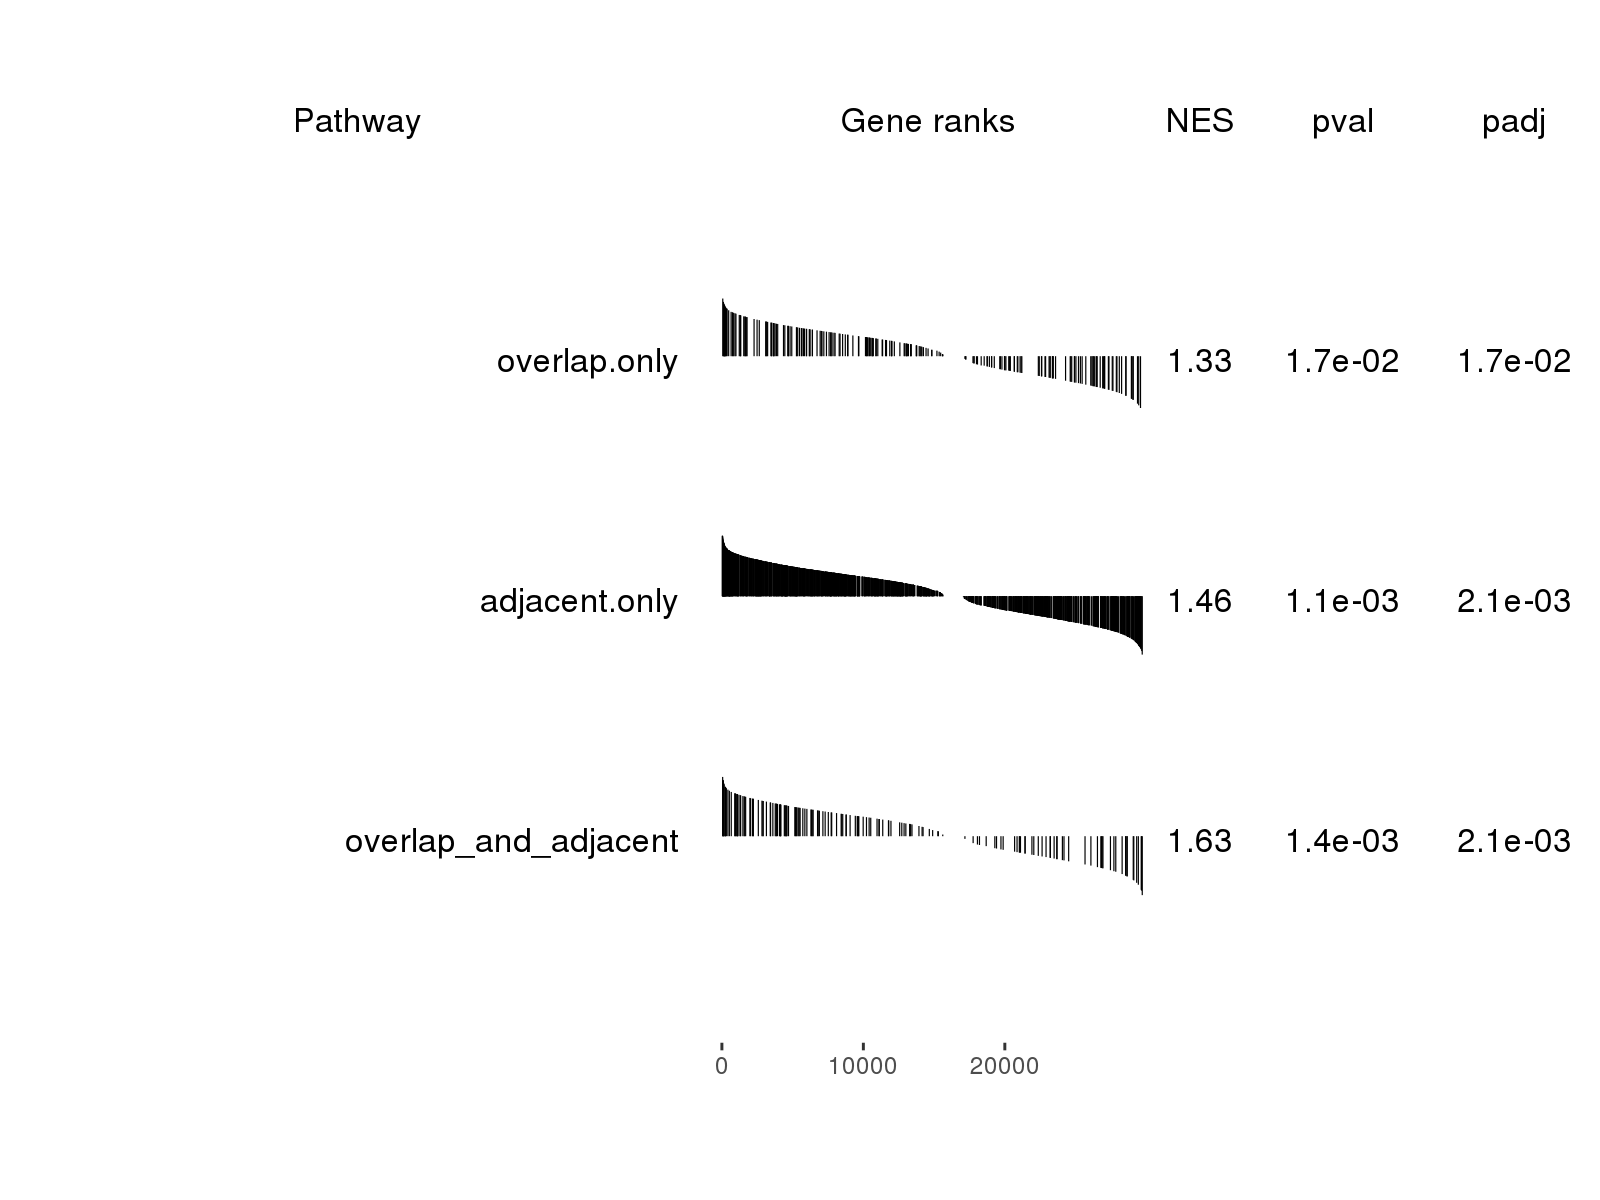

In [1141]:
plotGseaTable(my.gene.set, D7.WT, fgseaRes2, gseaParam = .5)

In [997]:
adjacent.genes %>% str
setdiff(overlap.genes, adjacent.genes) %>% str

 chr [1:1612] "PCMTD1" "SNTG1" "ADHFE1" "CPA6" "EYA1" "KCNB2" "PKHD1" ...
 chr [1:263] "COL19A1" "HS6ST1" "VWA3B" "TSGA10" "SATB2" "CREB1" "SNED1" ...


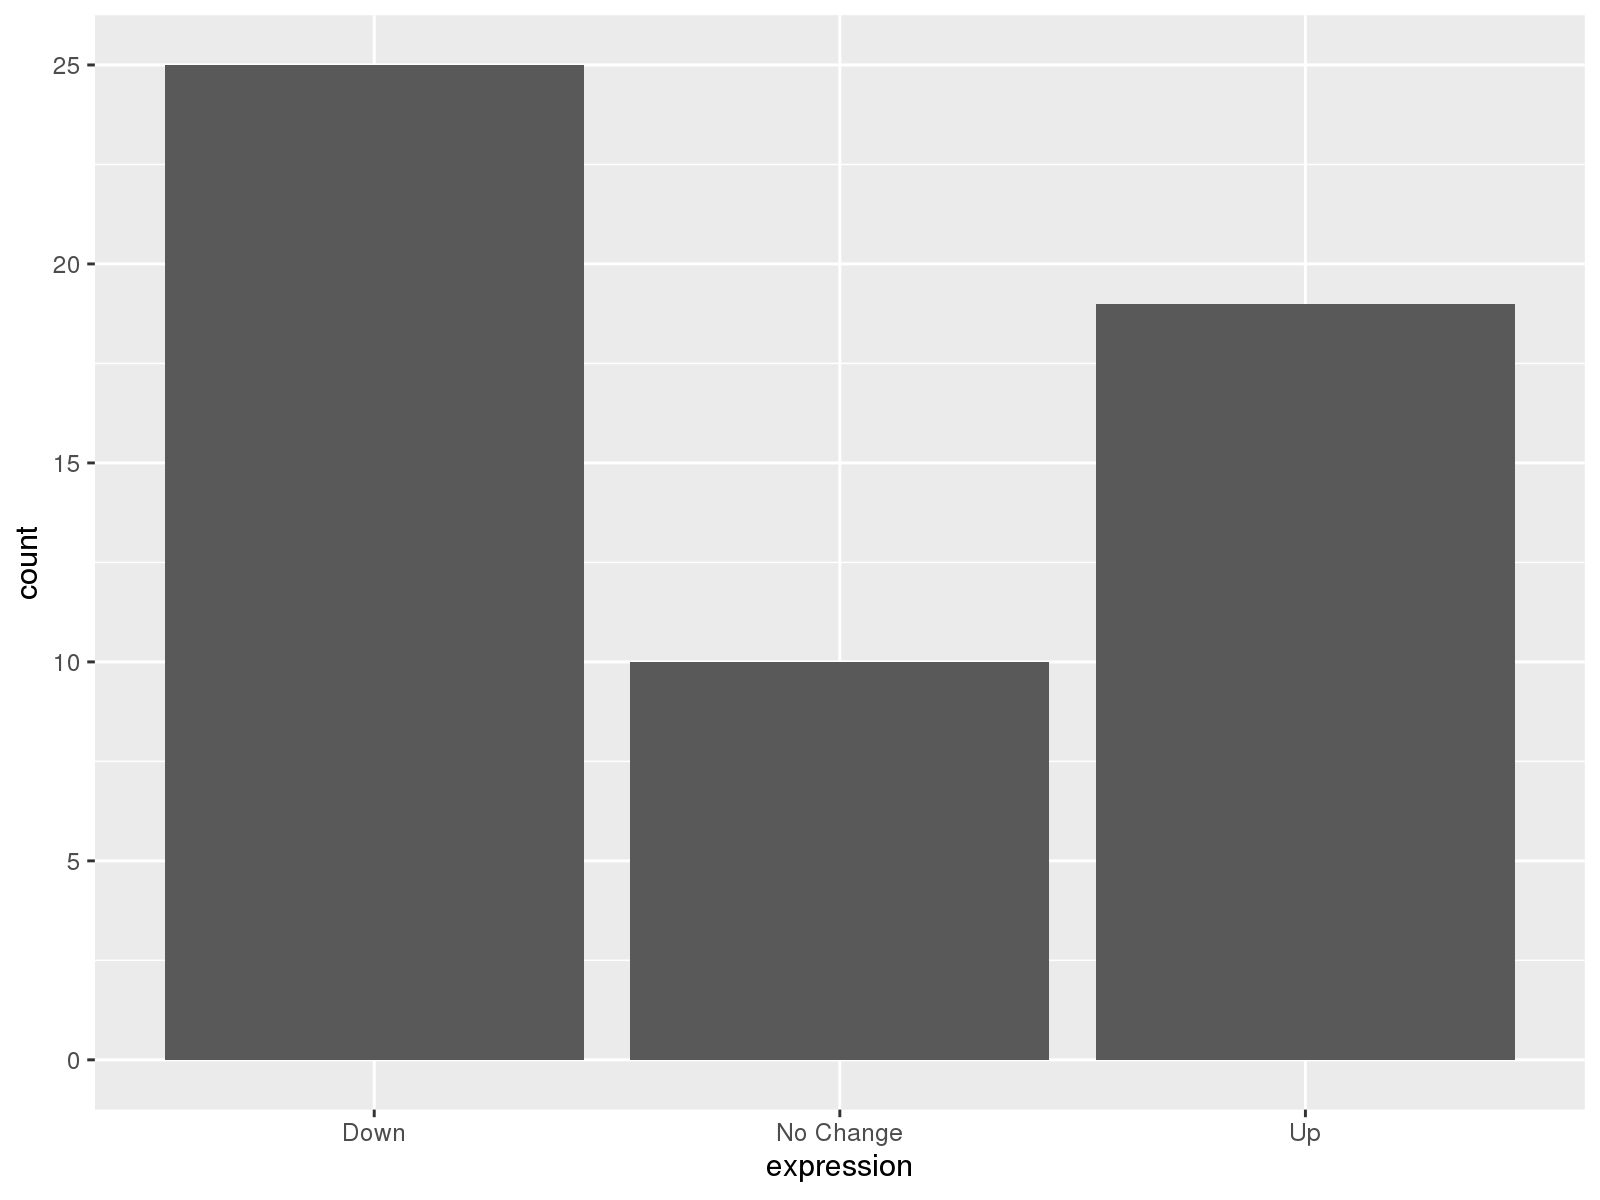

In [1000]:
D4.ZB18.KO %>% filter(gene %in% overlap.genes) %>% select(gene_id:log2FoldChange, expression) %>%
    ggplot() + geom_bar(aes(expression))

## what do we look for? 
 
- Do overlapping sites have higher FC vs. adjacent sites? Seems like it. 
-  Are overlapping sites enriched with hits vs. non hits? (not really)
- Are overlapping sites enriched in up (or down) regulated genes? (tbd)

In [739]:
mean(overlap.sites$fcA)

[1] 25.59891

In [924]:
mean(adjacent.sites$fcA)

[1] 24.73046

In [926]:
data.frame(fc = c(overlap.sites$fcB, adjacent.sites$fcB), 
           cat=c(rep("overlap", length(overlap.sites$fcB)), rep("adjacent", length(adjacent.sites$fcB))))  %>%
lm(fc ~ cat, data = ., ) %>% anova

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
cat,1,416.7077,416.7077,2.276996,0.131421
Residuals,2746,502539.0341,183.0077,NA,NA


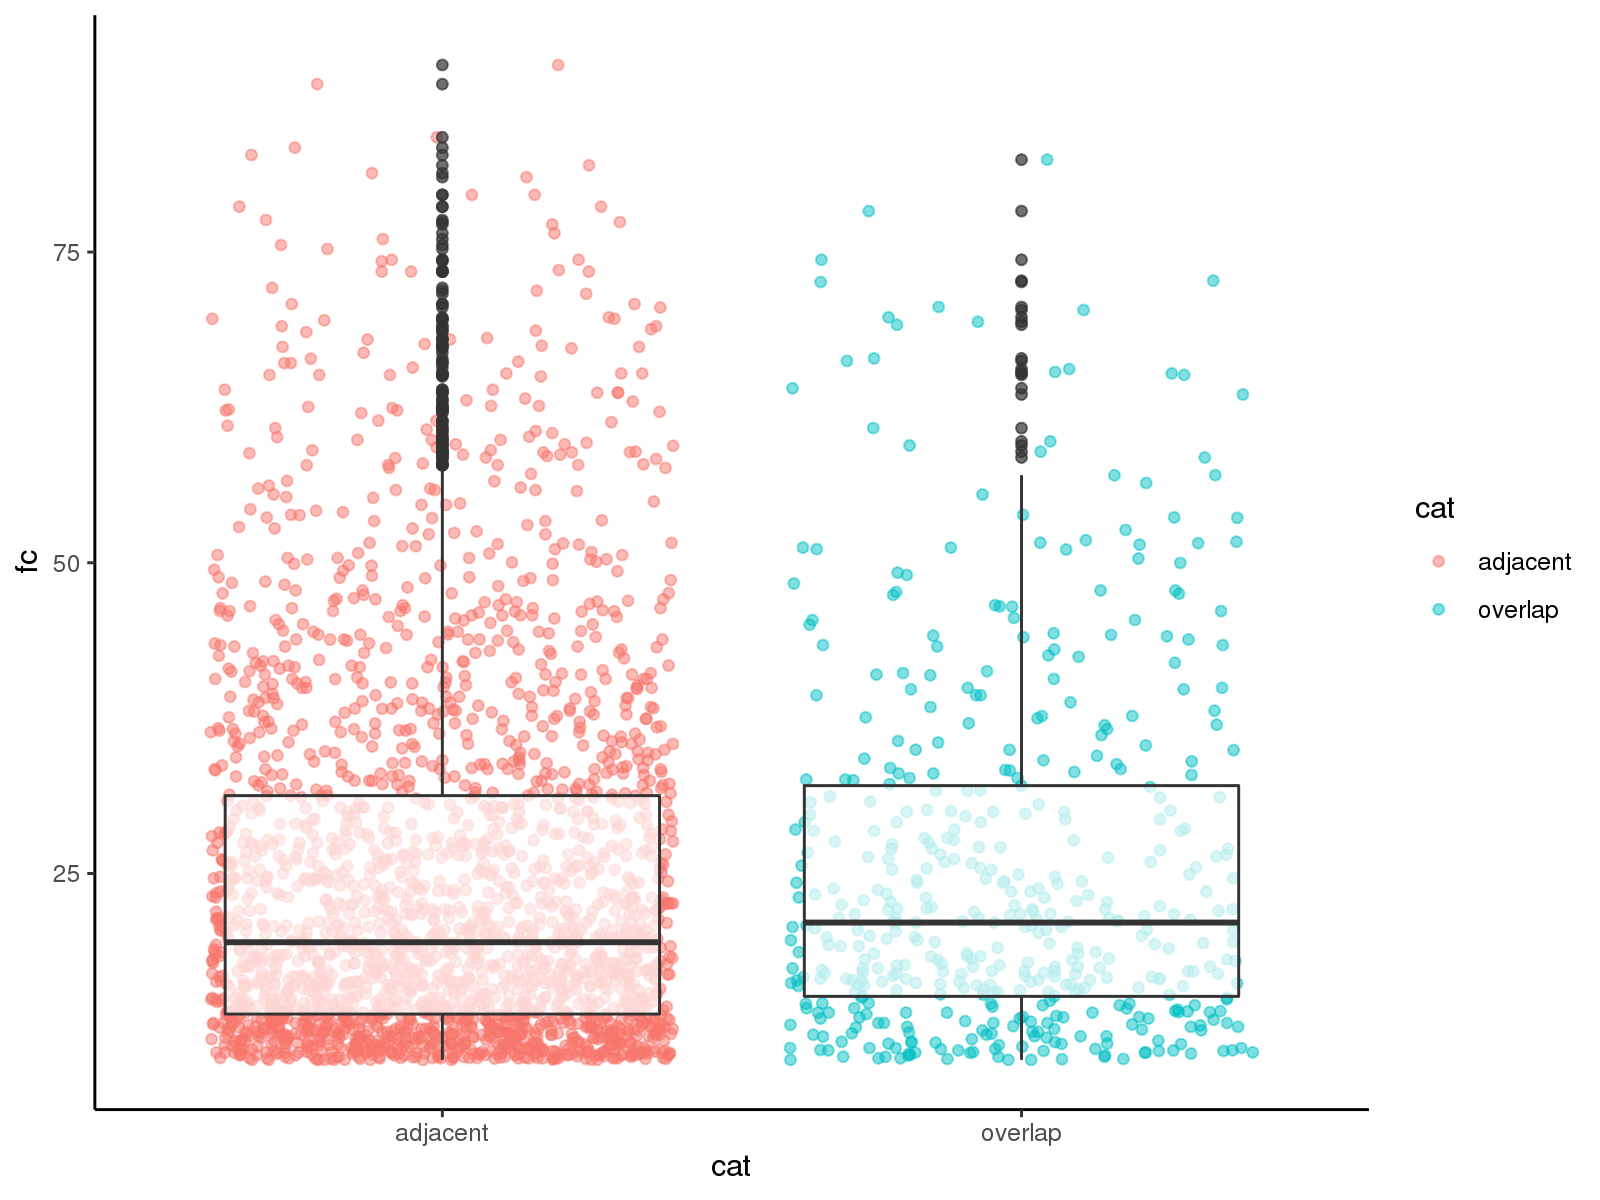

In [930]:
data.frame(fc = c(overlap.sites$fcA, adjacent.sites$fcA), 
           cat=c(rep("overlap", length(overlap.sites$fcA)), rep("adjacent", length(adjacent.sites$fcA))) ) %>% 
    ggplot() + geom_point(aes(cat, fc, color = cat), position = "jitter", alpha = .5) +
                geom_boxplot(aes(cat, fc), alpha = .7) +
                theme_classic()

In [1083]:
overlap.sites %>% filter(isHit) %>% pull(gene) %>% unique


adjacent.sites %>% filter(isHit) %>% pull(gene) %>% unique


[1] "LHX4"   "ARID1B" "SKI"    "RBPJ"

[1] "LHX4"   "CRY1"   "EBF1"   "NR1I2"  "ARID1B" "PAX2"   "PAX7"   "POU2F3"
[9] "SMAD3"

In [1087]:
overlap.genes %>% unique

[1] "RIMS1"         "COL19A1"       "HS6ST1"        "VWA3B"        
  [5] "TSGA10"        "SATB2"         "CREB1"         "TNS1"         
  [9] "PAX3"          "ESPNL"         "SNED1"         "R3HDM1"       
 [13] "RAB7B"         "NUAK2"         "CNTN2"         "ATP2B4"       
 [17] "NAV1"          "RGS8"          "LHX4"          "ABL2"         
 [21] "ASTN1"         "RCSD1"         "FAM78B"        "SMYD3"        
 [25] "STUM"          "SUSD4"         "DISP1"         "RAB3GAP2"     
 [29] "GPATCH2"       "ESRRG"         "RPS6KC1"       "TRAF5"        
 [33] "IYD"           "UTRN"          "ZC2HC1B"       "MAP3K5"       
 [37] "EYA4"          "ENPP3"         "NKAIN2"        "ANK3"         
 [41] "CCDC6"         "FAM13C"        "COL18A1"       "GM18596"      
 [45] "TSPEAR"        "ANO4"          "SYT1"          "A930009A15RIK"
 [49] "LGR5"          "GRIP1"         "KIF5A"         "RBMS2"        
 [53] "COBL"          "MDH1"          "SH3PXD2B"      "KCNIP1"       
 [57] "WWC1"          "SGCD"          "CDC42SE2"      "OBSCN"        
 [61] "RAI1"          "GSG1L2"        "GLP2R"         "NTN1"         
 [65] "CHD3"          "DNAH2"         "RTN4RL1"       "RPH3AL"       
 [69] "MYO1D"         "GM11563"       "KRTAP4-13"     "GM11564"      
 [73] "GM11567"       "JUP"           "ITGB3"         "SLC39A11"     
 [77] "SDK2"          "KIF19A"        "TBCD"          "MYT1L"        
 [81] "TPO"           "PRKAR2B"       "DOCK4"         "PRKD1"        
 [85] "DAAM1"         "MNAT1"         "ACTN1"         "RGS6"         
 [89] "FLVCR2"        "TTLL5"         "NRXN3"         "FLRT2"        
 [93] "SETD3"         "KLC1"          "PACS2"         "ZMYND11"      
 [97] "ELMO1"         "OLFR11"        "FARS2"         "SPOCK1"       
[101] "AGTPBP1"       "FAM172A"       "AP3B1"         "IQGAP2"       
[105] "MAST4"         "ERBIN"         "PDE4D"         "FGF10"        
[109] "FHIT"          "THRB"          "ADK"           "ZCCHC24"      
[113] "ERC2"          "CHAT"          "ERCC6"         "GRID1"        
[117] "SLC7A7"        "SCARA5"        "EPHX2"         "DGKH"         
[121] "KLHL1"         "DACH1"         "GPC6"          "OXCT1"        
[125] "ADAMTS12"      "MYO10"         "DAP"           "SPAG1"        
[129] "LRP12"         "FBXO32"        "NSMCE2"        "FAM49B"       
[133] "ASAP1"         "CACNG2"        "MRTFA"         "NFAM1"        
[137] "PARVB"         "CELSR1"        "PRICKLE1"      "NELL2"        
[141] "ENDOU"         "SPATS2"        "RACGAP1"       "ASIC1"        
[145] "LITAF"         "SEMA5B"        "SLC15A2"       "HGD"          
[149] "GPR156"        "ALCAM"         "CMSS1"         "FILIP1L"      
[153] "4930453N24RIK" "SMIM11"        "KCNJ6"         "DSCAM"        
[157] "ARID1B"        "TULP4"         "SFT2D1"        "PDE10A"       
[161] "GM3435"        "GM3448"        "TBC1D24"       "ERGIC1"       
[165] "PPARD"         "ZNRD1"         "ZNRD1AS"       "MYMX"         
[169] "TREM3"         "UNC5CL"        "KIF6"          "RFTN1"        
[173] "FBXL17"        "TOGARAM2"      "CRIM1"         "GALM"         
[177] "KCNK12"        "FBXO11"        "FSHR"          "NRXN1"        
[181] "COLEC12"       "LAMA3"         "FHOD3"         "CELF4"        
[185] "SNX24"         "MEGF10"        "WDR7"          "NEDD4L"       
[189] "ZBTB7C"        "PIAS2"         "SETBP1"        "FADS2"        
[193] "GNA14"         "TRPM3"         "KCNV2"         "JAK2"         
[197] "KIF20B"        "CPEB3"         "CC2D2B"        "LCOR"         
[201] "SLIT1"         "CNNM1"         "XPNPEP1"       "ACSL5"        
[205] "ZDHHC6"        "ABLIM1"        "ATRNL1"        "GFRA1"        
[209] "IL2RA"         "ITGA8"         "STAM"          "NEBL"         
[213] "PIP4K2A"       "ARHGAP21"      "RALGDS"        "ABL1"         
[217] "ACVR1"         "CERS6"         "MYO3B"         "METTL8"       
[221] "RAPGEF4"       "CHRNA1"        "CD82"          "EXT2"         
[225] "HIPK3"         "ANO3"          "TMC2"          "MACROD2"      
[229] "CFAP6

In [1085]:
adjacent.genes

[1] "PCMTD1"        "SNTG1"         "ADHFE1"        "CPA6"         
   [5] "EYA1"          "KCNB2"         "PKHD1"         "KCNQ5"        
   [9] "RIMS1"         "DST"           "TMEM131"       "INPP4A"       
  [13] "2010300C02RIK" "AFF3"          "LONRF2"        "CHST10"       
  [17] "MYO1B"         "STAT1"         "PLCL1"         "CDK15"        
  [21] "NRP2"          "KLF7"          "AKR1CL"        "PTH2R"        
  [25] "MAP2"          "ERBB4"         "MREG"          "TMEM169"      
  [29] "IGFBP5"        "TNS1"          "PNKD"          "CATIP"        
  [33] "VIL1"          "TTLL4"         "WNT10A"        "PAX3"         
  [37] "GM45261"       "SPHKAP"        "DNER"          "A630001G21RIK"
  [41] "ARMC9"         "SH3BP4"        "AGAP1"         "ACKR3"        
  [45] "LRRFIP1"       "ESPNL"         "OLFR1414"      "GPR35"        
  [49] "KIF1A"         "HDLBP"         "CNTNAP5B"      "CDH20"        
  [53] "RNF152"        "PHLPP1"        "GLI2"          "CFAP221"      
  [57] "3110009E18RIK" "NCKAP5"        "TMEM163"       "THSD7B"       
  [61] "MAPKAPK2"      "CNTN2"         "NFASC"         "LRRN2"        
  [65] "PIK3C2B"       "PLEKHA6"       "MYOG"          "PPFIA4"       
  [69] "SYT2"          "NAV1"          "CACNA1S"       "KIF21B"       
  [73] "NR5A2"         "LHX9"          "DENND1B"       "BRINP3"       
  [77] "FAM129A"       "EDEM3"         "1700025G04RIK" "RGL1"         
  [81] "NCF2"          "NMNAT2"        "LAMC1"         "CACNA1E"      
  [85] "BC034090"      "ACBD6"         "LHX4"          "TEX35"        
  [89] "ASTN1"         "TNR"           "DNM3"          "MYOC"         
  [93] "NME7"          "ILDR2"         "FAM78B"        "LMX1A"        
  [97] "OLFML2B"       "DEDD"          "CFAP45"        "PLD5"         
 [101] "SDCCAG8"       "AKT3"          "KIF26B"        "SMYD3"        
 [105] "CDC42BPA"      "DNAH14"        "SUSD4"         "DISP1"        
 [109] "TGFB2"         "ESRRG"         "USH2A"         "KCNK2"        
 [113] "PTPN14"        "HHAT"          "SYT14"         "CAMK1G"       
 [117] "PLXNA2"        "CCDC170"       "ESR1"          "KATNA1"       
 [121] "SASH1"         "UTRN"          "PHACTR2"       "AIG1"         
 [125] "NHSL1"         "MAP3K5"        "SGK1"          "EYA4"         
 [129] "AKAP7"         "SMLR1"         "ARHGAP18"      "LAMA2"        
 [133] "SOGA3"         "NCOA7"         "TRDN"          "LAMA4"        
 [137] "FYN"           "MFSD4B1"       "FIG4"          "SCML4"        
 [141] "SOBP"          "1700021F05RIK" "PREP"          "PKIB"         
 [145] "CCDC138"       "SH3RF3"        "ASCC1"         "SPOCK2"       
 [149] "VSIR"          "CDH23"         "PALD1"         "LRRC20"       
 [153] "HKDC1"         "JMJD1C"        "ARID5B"        "RHOBTB1"      
 [157] "ANK3"          "CCDC6"         "UBE2D1"        "ADORA2A"      
 [161] "GUCD1"         "COL18A1"       "GM49918"       "TSPEAR"       
 [165] "KRTAP10-4"     "GM10318"       "TCF3"          "NFIC"         
 [169] "TXNRD1"        "CHST11"        "SLC41A2"       "APPL2"        
 [173] "NUAK1"         "CRY1"          "BTBD11"        "SYN3"         
 [177] "PAH"           "IGF1"          "MYBPC1"        "ANKS1B"       
 [181] "FGD6"          "PLXNC1"        "UBE2N"         "POC1B"        
 [185] "KITL"          "LRRIQ1"        "NAV3"          "CSRP2"        
 [189] "TPH2"          "TMEM19"        "GRIP1"         "HMGA2"        
 [193] "WIF1"          "MBD6"          "R3HDM2"        "TIMELESS"     
 [197] "NEUROD4"       "MTMR3"         "ZMAT5"         "GCK"          
 [201] "CAMK2B"        "PKD1L1"        "UPP1"          "ABCA13"       
 [205] "DDC"           "COBL"          "GM28048"       "CCDC85A"      
 [209] "EML6"          "ACYP2"         "SH3PXD2B"      "KCNMB1"       
 [213] "KCNIP1"        "DOCK2"         "SLIT3"         "TENM2"        
 [217] "ATP10B"        "ADRA1B"        "EBF1"          "CLINT1"       
 [221] "ADAM19"        "SGCD"          "RASGEF1C"      "RNF130"       
 [225] "MAML1"         "ADA

In [790]:
setdiff( adjacent.genes, overlap.genes) %>% intersect(hitlist$hgnc_symbol)

[1] "ZBTB18" "CRY1"   "EBF1"   "ZFP2"   "NR1I2"  "PAX2"   "PAX7"   "POU2F3"
[9] "SMAD3"

overlapping genes: hits vs non-hit

In [729]:
intersect(overlap.genes, hitlist$hgnc_symbol) %>% length
setdiff(overlap.genes, hitlist$hgnc_symbol) %>% length

[1] 4

[1] 440

adjacent genes: hits vs non-hit

In [1081]:
intersect(overlap.genes, hitlist$hgnc_symbol) %>% length
setdiff(overlap.genes, hitlist$hgnc_symbol) %>% length

[1] 4

[1] 440

In [1080]:
length(overlap.genes)

[1] 444



---

# HEATMAP

In [18]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.0.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.




In [21]:
NGN2_tomtom %>% head

target_ID,P,Name,median_l2fc
<chr>,<dbl>,<chr>,<dbl>
MA0002.1,0.6235070,RUNX1,5.149426
MA0003.4,0.0034506,TFAP2A,4.380018
MA0014.3,0.7386330,PAX5,4.259507
MA0017.2,0.2806740,NR2F1,6.671046
MA0024.3,0.8610100,E2F1,5.738699
MA0027.2,0.5531230,EN1,2.947371


In [31]:
pre.mat <- filter(tomtom.ed, query_ID %in% NGN2_tomtom$target_ID & target_ID %in% NGN2_tomtom$target_ID) %>%
                select(query_ID, target_ID, p) %>%
                left_join(NGN2_tomtom[, c("target_ID", "Name")], by = c("query_ID" = "target_ID")) %>%
                rename("query_gene" = "Name") %>%
                left_join(NGN2_tomtom[, c("target_ID", "Name")], by = "target_ID") %>%
                rename("target_gene" = "Name")

In [35]:
head(pre.mat)

query_ID,target_ID,p,query_gene,target_gene
<chr>,<chr>,<dbl>,<chr>,<chr>
MA1574.1,MA1574.1,0.00000e+00,THRB,THRB
MA1574.1,MA1537.1,2.78999e-15,THRB,NR2F1(var.2)
MA1574.1,MA0855.1,1.00923e-10,THRB,RXRB
MA1574.1,MA1112.2,1.48725e-04,THRB,NR4A1
MA1574.1,MA1111.1,2.05624e-04,THRB,NR2F2
MA1574.1,MA0017.2,4.15415e-04,THRB,NR2F1


In [36]:
mat <- select(pre.mat, query_gene, target_gene, p) %>%
            filter(p != 0) %>%
            mutate_at("p", ~ -log10(.x)) %>%
            pivot_wider(names_from = "target_gene", values_from = "p") %>%
            column_to_rownames("query_gene") %>%
            as.matrix

In [37]:
head(mat)

,NR2F1(var.2),RXRB,NR4A1,NR2F2,NR2F1,NR1D2,NR1I3,NR2F1(var.3),USF1,USF2,⋯,VSX1,MAX::MYC,E2F8,TLX2,EMX1,ZNF140,SMAD3,PAX4,POU3F2,THRB
THRB,14.55439735,9.996009848,3.8276160,3.6869262,3.38151783,3.1825966,3.058143853,2.730206956,2.5465670,2.5215230,⋯,0.009287404,0.008100847,5.697368e-03,3.907502e-03,0.003332500,0.0030350070,0.0016839803,1.681800e-03,0.001312683,NA
TFAP4(var.2),0.12777320,0.032315860,0.2014163,0.2044425,0.74280398,0.0853623,0.137603830,0.002091815,2.4698054,2.5982343,⋯,0.076676696,3.260659499,4.049508e-03,1.186673e-01,0.004021015,0.0048555282,0.0272451530,1.317230e-02,0.512060263,0.19104872
TBX3,0.12270239,0.171425811,0.3343937,0.4951460,0.81912608,0.9967463,0.105324574,0.493405683,0.7275944,0.7914888,⋯,0.001612049,0.411202975,3.684519e-02,5.733066e-05,0.000142472,0.9096608111,0.0314712895,5.733066e-05,0.026891089,0.39217411
TCF21(var.2),0.11297717,0.014314913,0.2915876,0.1694569,0.09986674,0.2028634,0.002847429,0.003079181,1.8645811,1.9407548,⋯,0.093806154,2.936479000,2.165588e-01,2.237286e-02,0.008790321,0.0005710382,0.0004497276,3.649975e-02,1.034372213,0.27593313
MNT,0.04889281,0.000531902,0.3014210,0.7262975,0.44904069,0.1386556,0.073843867,0.131275057,2.3864298,2.6390016,⋯,0.082663095,5.840210303,3.604794e-05,1.741333e-01,0.053931597,0.0611896750,0.0082154617,2.260796e-02,0.094396223,0.04517978
FOS::JUNB,0.09950998,0.197823070,1.0801952,1.2363968,1.86512195,0.6625607,0.452126882,0.340840911,0.8486608,0.8839537,⋯,0.375898468,0.002509205,0.000000e+00,4.451633e-01,0.300107666,0.0475674394,0.0162289722,2.433958e-01,0.082449330,0.15409183


In [70]:
an = NGN2_tomtom$median_l2fc
names(an) = NGN2_tomtom$Name

RUNX1 
5.149426

In [65]:
NGN2_tomtom %>% select(Name, median_l2fc) %>% head

Name,median_l2fc
<chr>,<dbl>
RUNX1,5.149426
TFAP2A,4.380018
PAX5,4.259507
NR2F1,6.671046
E2F1,5.738699
EN1,2.947371


In [440]:
col_fun = circlize::colorRamp2(c(0, 2, 4, 8, 10), c("royalblue", "white", "white", "tomato3", "tomato"))

In [441]:
col_fun(seq(0, 15))

[1] "#4169E1FF" "#AEB1F1FF" "#FFFFFFFF" "#FFFFFFFF" "#FFFFFFFF" "#FAD3CAFF"
 [7] "#F0A897FF" "#E17D67FF" "#CD4F39FF" "#E65940FF" "#FF6347FF" "#FF6347FF"
[13] "#FF6347FF" "#FF6347FF" "#FF6347FF" "#FF6347FF"

In [493]:
ht1 <- ComplexHeatmap::Heatmap(mat, col = col_fun, name = "Motif similarity \n -log10(p-val)", 
                               top_annotation = col_ha,
                        cluster_rows = T, cluster_columns = T, 
                        show_column_names = F, show_row_names = F,
                        show_row_dend = F, show_column_dend = F, 
                        
                        ) 

In [436]:
row_order(ht1)[1:20]
column_order(ht1)[1:20]


[1]  11  66  67 164  26   6   7   9 144 116 197 167 122  62 140 173  72  99 172
[20]  65

[1] 124 121 113 114  95 140 155 150 152 109 112  89  93  66  79 100 174 172  82
[20]  81

In [457]:
runif(5)

[1] 0.1745944 0.2755326 0.4117933 0.6030549 0.2890999

In [458]:
mat[1:5, 1:5]

,NR2F1(var.2),RXRB,NR4A1,NR2F2,NR2F1
THRB,14.55439735,9.996009848,3.8276160,3.6869262,3.38151783
TFAP4(var.2),0.12777320,0.032315860,0.2014163,0.2044425,0.74280398
TBX3,0.12270239,0.171425811,0.3343937,0.4951460,0.81912608
TCF21(var.2),0.11297717,0.014314913,0.2915876,0.1694569,0.09986674
MNT,0.04889281,0.000531902,0.3014210,0.7262975,0.44904069


In [462]:
head(NGN2_tomtom)

target_ID,P,Name,median_l2fc
<chr>,<dbl>,<chr>,<dbl>
MA0002.1,0.6235070,RUNX1,5.149426
MA0003.4,0.0034506,TFAP2A,4.380018
MA0014.3,0.7386330,PAX5,4.259507
MA0017.2,0.2806740,NR2F1,6.671046
MA0024.3,0.8610100,E2F1,5.738699
MA0027.2,0.5531230,EN1,2.947371


In [467]:
col_l2fc <- map_dbl(colnames(mat), ~ filter(NGN2_tomtom, Name == .x) %>% pull(median_l2fc) %>% .[1])

In [492]:
col_ha <- HeatmapAnnotation(l2fc = col_l2fc, col = list(l2fc = col_fun), gp = gpar(col = "black"), )

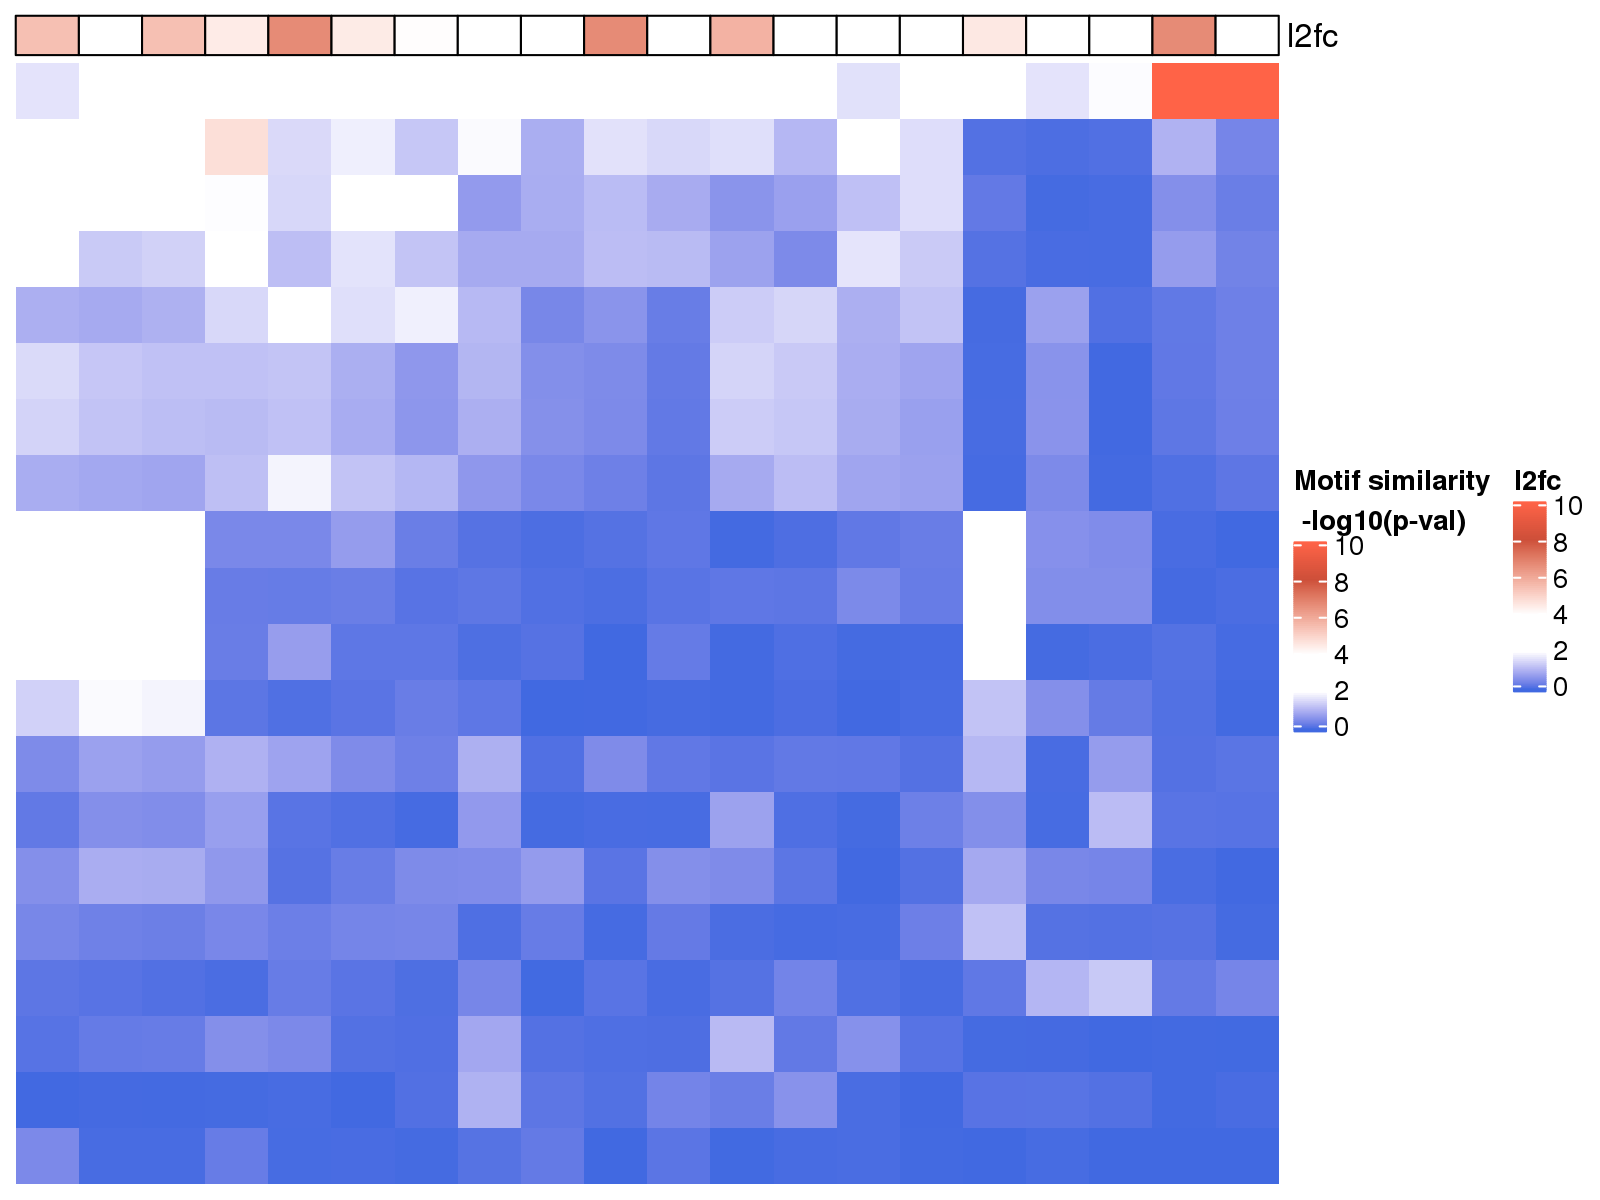

In [494]:
draw(ht1[1:20, 1:20])

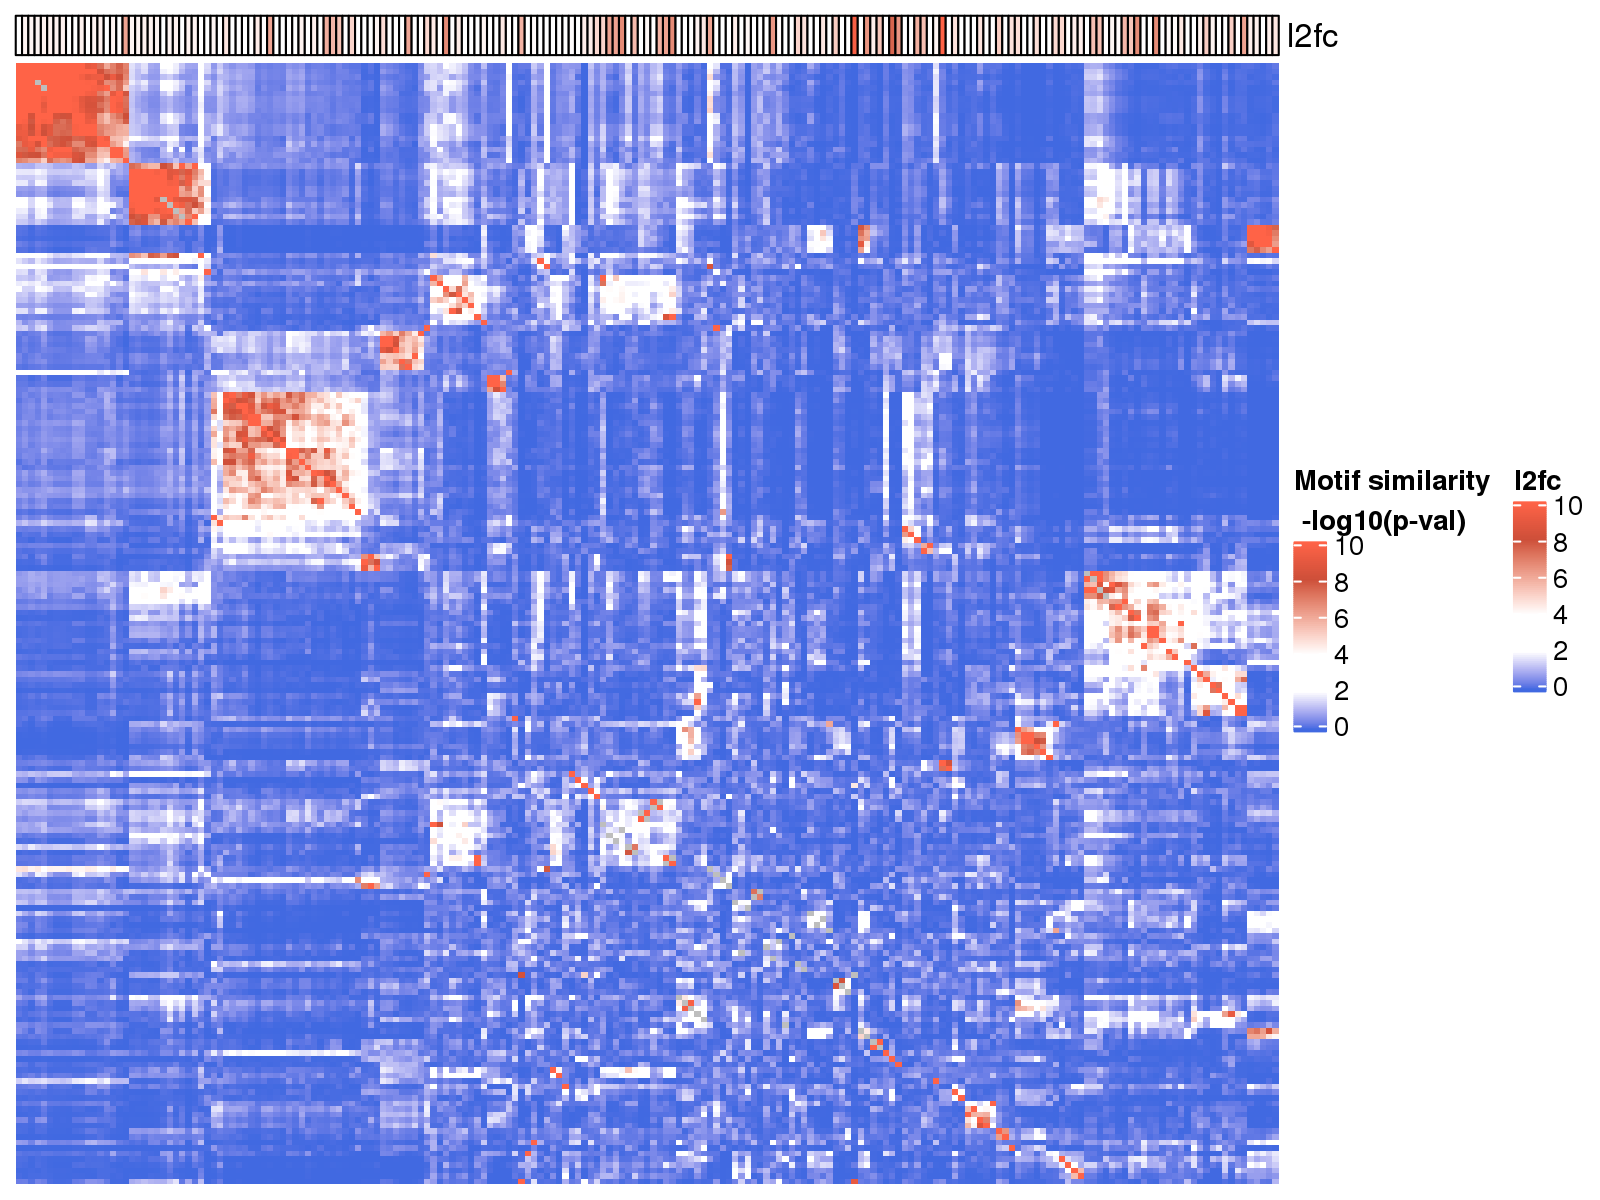

In [495]:
draw(ht1)

---

# Centrimo analysis

### ZBTB18 mouse chip

In [630]:
zb18.centrimo <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/mouse_chip_mazzoni/memechip_out_V2_ZB18_WT/centrimo_out/centrimo.txt", skip = 2, n_max = 152, col_names = F)

zb18.centrimo <- rename(zb18.centrimo, "motif"="X2", "gene"="X3", "adj_p"="X5")

zb18.centrimo <- mutate_at(zb18.centrimo, "motif", ~ str_remove(.x, "^[0-9]+") %>% str_trim) %>%
                    filter(str_detect(motif, "^MA[0-9]")) %>%
                    select(motif, gene, adj_p)


zb18.centrimo <-  mutate(zb18.centrimo, adj_p2 = if_else(adj_p != 0, -log10(adj_p), 350))

In [634]:
zb18.centrimo %>% mutate( anno = if_else(adj_p2 > 100, gene, NULL)) %>% head

motif,gene,adj_p,adj_p2,anno
<chr>,<chr>,<dbl>,<dbl>,<chr>
MA1100.2,ASCL1,0.0e+00,350.0000,ASCL1
MA1631.1,ASCL1(var.2),2.9e-142,141.5376,ASCL1(var.2)
MA0816.1,Ascl2,1.9e-297,296.7212,Ascl2
MA0461.2,Atoh1,3.8e-254,253.4202,Atoh1
MA1467.1,ATOH1(var.2),5.0e-215,214.3010,ATOH1(var.2)
MA1468.1,ATOH7,2.0e-215,214.6990,ATOH7


In [692]:
zb18.centrimo %>% arrange(-adj_p2) %>% head(10)

motif,gene,adj_p,adj_p2
<chr>,<chr>,<dbl>,<dbl>
MA1100.2,ASCL1,0.0e+00,350.0000
MA0607.1,Bhlha15,0.0e+00,350.0000
MA1472.1,BHLHA15(var.2),0.0e+00,350.0000
MA1619.1,Ptf1a(var.2),0.0e+00,350.0000
MA0698.1,ZBTB18,0.0e+00,350.0000
MA1641.1,MYF5,6.4e-312,311.1938
MA1618.1,Ptf1a,2.1e-307,306.6778
MA1123.2,TWIST1,6.3e-304,303.2007
MA0816.1,Ascl2,1.9e-297,296.7212


Warning message:
“Removed 120 rows containing missing values (geom_text).”


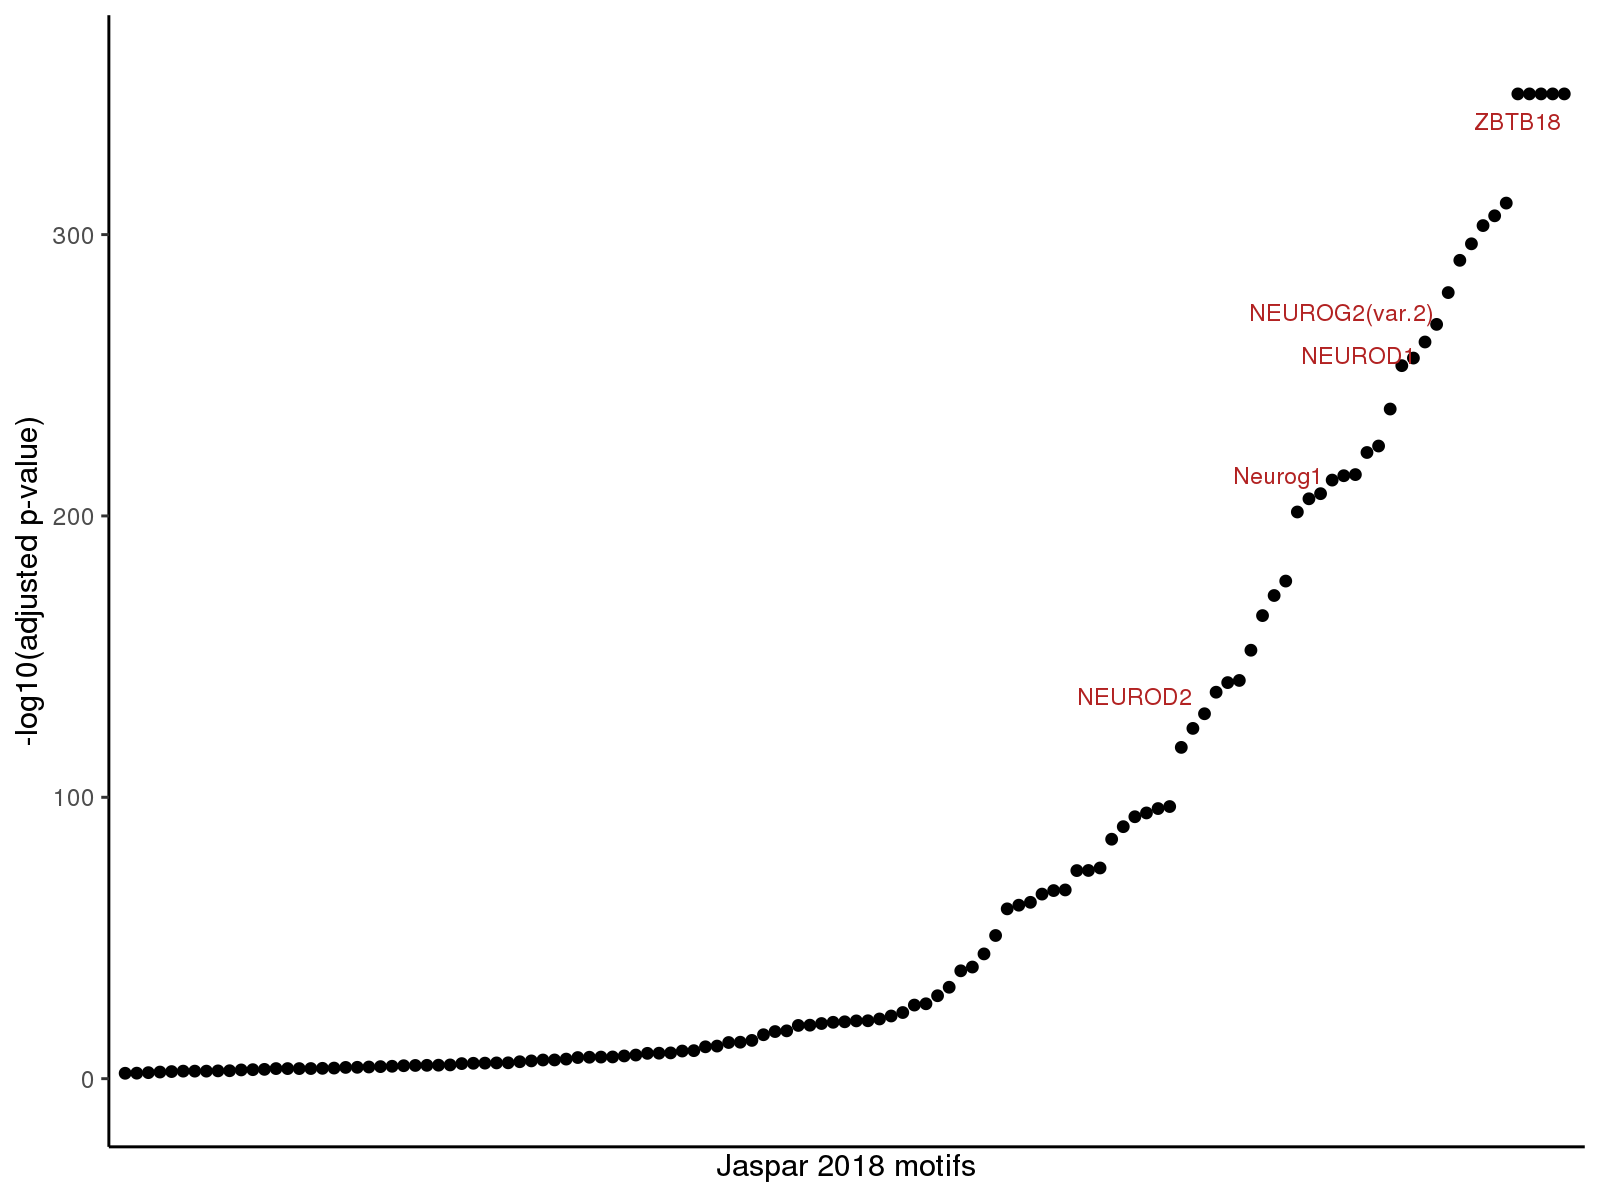

In [643]:
zb18.centrimo %>% mutate( anno = if_else(adj_p2 > 100 & str_detect(gene, "(ZB)|(NEU)|(Neu)"), gene, NULL))  %>%
    ggplot() + geom_point(aes(fct_reorder(motif, adj_p2), adj_p2)) +
        geom_text(aes(motif, adj_p2, label = anno), size = 3, color = "firebrick",  
                  position = position_jitter(width = 3, height = 10, seed = 123), vjust="inward",hjust="inward") +
        theme_classic() +
        labs(x = "Jaspar 2018 motifs", y = "-log10(adjusted p-value)") +
        scale_x_discrete(breaks = NULL)

### NGN2 chip

In [644]:
ngn2.centrimo <- read_table2("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/mouse_chip_mazzoni/memechip_out_V2_NGN2_WT/centrimo_out/centrimo.txt", 
                             skip = 2, n_max = 141, col_names = F)

ngn2.centrimo <- rename(ngn2.centrimo, "motif"="X2", "gene"="X3", "adj_p"="X5")

ngn2.centrimo <- mutate_at(ngn2.centrimo, "motif", ~ str_remove(.x, "^[0-9]+") %>% str_trim) %>%
                    filter(str_detect(motif, "^MA[0-9]")) %>%
                    select(motif, gene, adj_p)


ngn2.centrimo <-  mutate(ngn2.centrimo, adj_p2 = if_else(adj_p != 0, -log10(adj_p), 350))

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_double(),
  X13 = col_double(),
  X14 = col_double()
)



In [645]:
head(ngn2.centrimo)

motif,gene,adj_p,adj_p2
<chr>,<chr>,<dbl>,<dbl>
MA1100.2,ASCL1,0.0e+00,350.0000
MA1631.1,ASCL1(var.2),1.7e-268,267.7696
MA0816.1,Ascl2,0.0e+00,350.0000
MA0461.2,Atoh1,0.0e+00,350.0000
MA1467.1,ATOH1(var.2),0.0e+00,350.0000
MA1468.1,ATOH7,0.0e+00,350.0000


Warning message:
“Removed 115 rows containing missing values (geom_text).”


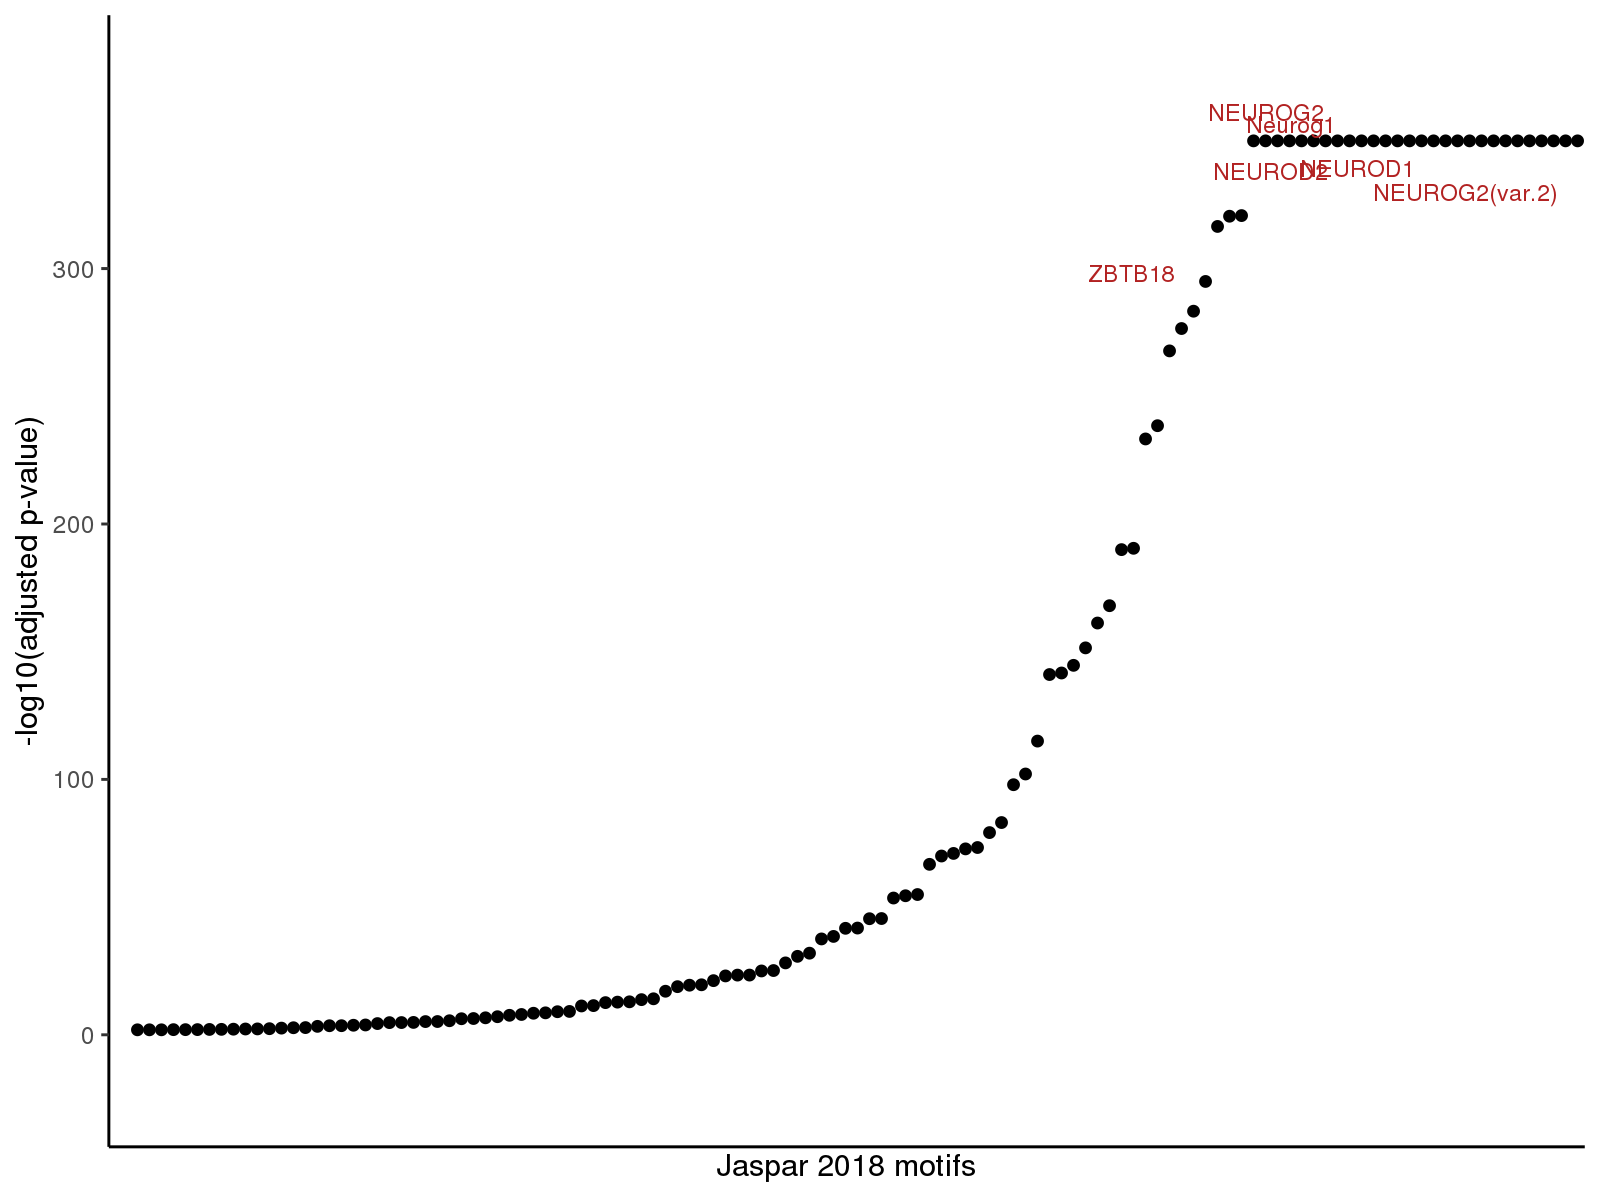

In [649]:
ngn2.centrimo %>% mutate( anno = if_else(adj_p2 > 100 & str_detect(gene, "(ZB)|(NEU)|(Neu)"), gene, NULL))  %>%
    ggplot() + geom_point(aes(fct_reorder(motif, adj_p2), adj_p2)) +
        geom_text(aes(motif, adj_p2, label = anno), size = 3, color = "firebrick",  
                  position = position_jitter(width = 3, height = 30, seed = 123), vjust="inward",hjust="inward") +
        theme_classic() +
        labs(x = "Jaspar 2018 motifs", y = "-log10(adjusted p-value)") +
        scale_x_discrete(breaks = NULL)

# NGN2 and ZBTB18 co-occupancy

```intersectBed -u -f 0.5 -a ZB18_WT_peaks.narrowPeak -b NGN2_WT_peaks.narrowPeak > ZB18_x_NGN2_peaks.narro
wPeak```

result: 
```
58396   583960  4556236 NGN2_WT_peaks.narrowPeak
57955   579550  4515623 ZB18_WT_peaks.narrowPeak
28263   282630  2212901 ZB18_x_NGN2_peaks.narrowPeak
```

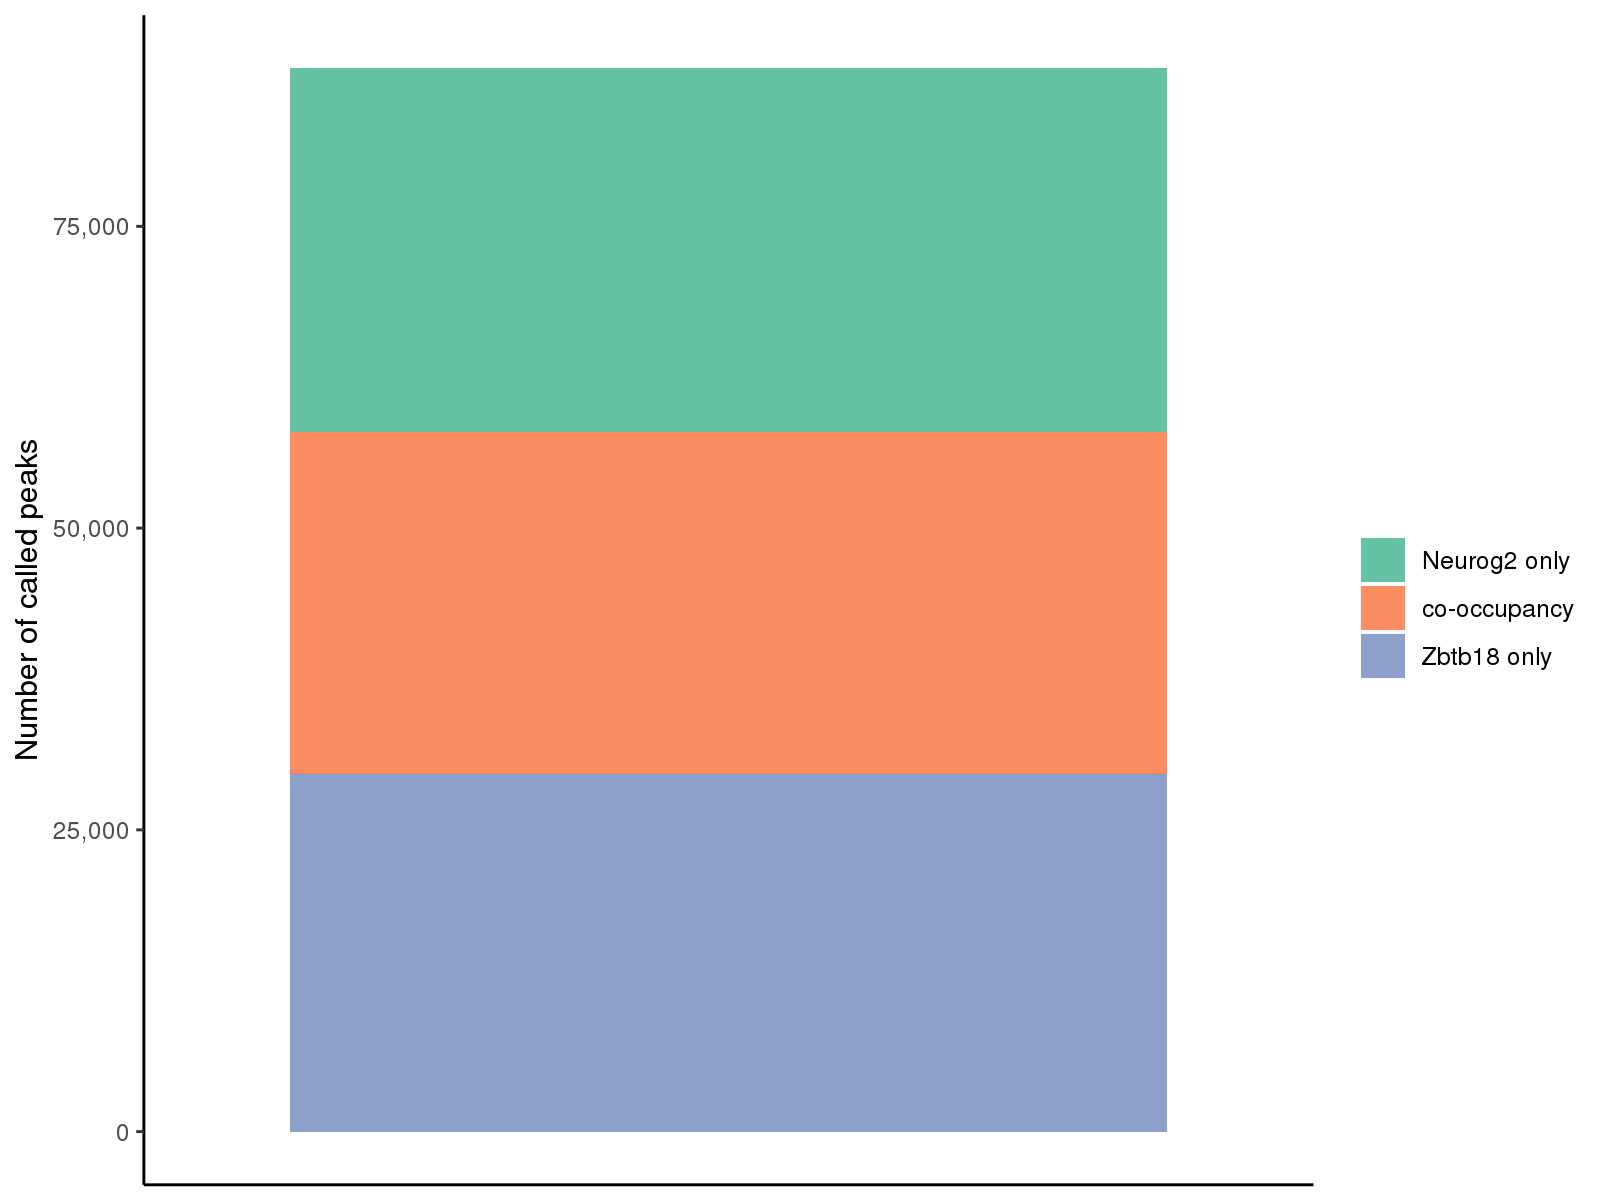

In [689]:
bar <- tribble(~ type, ~ peaks, 
              "co-occupancy", 28263,
              "Zbtb18 only", 57955 - 28263,
              "Neurog2 only", 58396 - 28263) %>%
            mutate_at("type", ~ factor(.x, c("Neurog2 only", "co-occupancy", "Zbtb18 only")))

ggplot(bar) + geom_col(aes("a", peaks, fill = type)) +
        theme_classic() + 
        scale_x_discrete(name = NULL, breaks = NULL) +
        scale_y_continuous(labels = scales::comma, name = "Number of called peaks") + 
        scale_fill_brewer(palette = "Set2") +
        theme(legend.title = element_blank())